# **CELL 1: Environment Setup**

In [1]:
# Install all required packages
!pip install --upgrade pip
!pip install torch torchvision torchaudio transformers datasets soundfile librosa accelerate scipy matplotlib seaborn psutil joblib streamlit pyngrok
!pip install audio-recorder-streamlit
!pip install streamlit-audiorec

import torch
print("CUDA available?", torch.cuda.is_available())
if torch.cuda.is_available():
    print("Device name:", torch.cuda.get_device_name(0))
else:
    print("Running on CPU")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 132.4 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 147.6 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [streamlit]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 86.3 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 813.6/813.6 kB 41.4 MB/s  0:00:00
  Attempting uninstall: altair
    Found existing installation: altair 5.5.0
    Uninstalling altair-5.5.0:
      Successfully uninstalled altair-5.5.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [audio-recorder-streamlit]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 872.8/872.8 kB 39.1 MB/s  0:00:00
CUDA available? True
Device name: Tesla T4


# **CELL 2: Mount Drive & Setup Paths**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

import os
DATASET_PATH = "/content/drive/MyDrive/Colab Notebooks/Datasets"
print("Dataset path:", DATASET_PATH)
print("Contents:", os.listdir(DATASET_PATH) if os.path.exists(DATASET_PATH) else "Path not found")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset path: /content/drive/MyDrive/Colab Notebooks/Datasets
Contents: ['iiit_hin_sukh.tar.gz', 'iiit_ben_ant.tar.gz', 'iiit_kan_lp.tar.gz', 'iiit_mal_abi.tar.gz', 'iiit_mar_ash.tar.gz', 'iiit_tam_moh.tar.gz', 'iiit_tel_baji.tar.gz', 'Accent_NLI_Output']


# **CELL 3: Extract All Datasets**

In [3]:
import tarfile
import os

# List of dataset files
dataset_files = [
    "iiit_ben_ant.tar.gz",
    "iiit_mal_abi.tar.gz",
    "iiit_tel_baji.tar.gz",
    "iiit_hin_sukh.tar.gz",
    "iiit_mar_ash.tar.gz",
    "iiit_kan_lp.tar.gz",
    "iiit_tam_moh.tar.gz"
]

# Extract each dataset
for dataset in dataset_files:
    file_path = os.path.join(DATASET_PATH, dataset)
    if os.path.exists(file_path):
        print(f"Extracting {dataset}...")
        with tarfile.open(file_path, 'r:gz') as tar:
            tar.extractall(path=DATASET_PATH)
        print(f"✓ {dataset} extracted")
    else:
        print(f"✗ {dataset} not found")

print("\nExtraction complete!")

Extracting iiit_ben_ant.tar.gz...


/tmp/ipython-input-1301303338.py:21: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(path=DATASET_PATH)


✓ iiit_ben_ant.tar.gz extracted
Extracting iiit_mal_abi.tar.gz...
✓ iiit_mal_abi.tar.gz extracted
Extracting iiit_tel_baji.tar.gz...
✓ iiit_tel_baji.tar.gz extracted
Extracting iiit_hin_sukh.tar.gz...
✓ iiit_hin_sukh.tar.gz extracted
Extracting iiit_mar_ash.tar.gz...
✓ iiit_mar_ash.tar.gz extracted
Extracting iiit_kan_lp.tar.gz...
✓ iiit_kan_lp.tar.gz extracted
Extracting iiit_tam_moh.tar.gz...
✓ iiit_tam_moh.tar.gz extracted

Extraction complete!


# **CELL 4: Inspect Dataset Structure & Detect Age/Speech Type**

In [5]:
import os
import pandas as pd
import re

# Map folder names to languages
language_map = {
    'iiit_ben_ant': 'Bengali',
    'iiit_mal_abi': 'Malayalam',
    'iiit_tel_baji': 'Telugu',
    'iiit_hin_sukh': 'Hindi',
    'iiit_mar_ash': 'Marathi',
    'iiit_kan_lp': 'Kannada',
    'iiit_tam_moh': 'Tamil'
}

# Function to detect age and speech type from file structure/metadata
def extract_metadata(filepath):
    """
    Extract age group and speech type from file path or filename
    Assumptions based on IIIT dataset structure:
    - Files may contain 'adult', 'child', 'kid' in path
    - Or infer from subdirectory structure
    - Speech type: 'word' vs 'sentence' from filename or folder
    """
    path_lower = filepath.lower()

    # Age detection
    if 'adult' in path_lower or 'grown' in path_lower:
        age = 'adult'
    elif 'child' in path_lower or 'kid' in path_lower or 'kids' in path_lower:
        age = 'child'
    else:
        # Default: if speaker name suggests adult (common names)
        # For IIIT datasets, most are adult unless specified
        age = 'adult'  # Default assumption

    # Speech type detection (word vs sentence)
    filename = os.path.basename(filepath)
    if 'word' in path_lower or re.search(r'w\d+', filename):
        speech_type = 'word'
    elif 'sentence' in path_lower or 'sent' in path_lower or re.search(r's\d+', filename):
        speech_type = 'sentence'
    else:
        # Default based on context - most IIIT recordings are sentences
        speech_type = 'sentence'

    return age, speech_type

# Build dataset with metadata
data_list = []
for folder, label in language_map.items():
    folder_path = os.path.join(DATASET_PATH, folder)
    if os.path.exists(folder_path):
        for root, dirs, files in os.walk(folder_path):
            for file in files:
                if file.endswith('.wav'):
                    filepath = os.path.join(root, file)
                    age, speech_type = extract_metadata(filepath)
                    data_list.append({
                        'filepath': filepath,
                        'label': label,
                        'age': age,
                        'speech_type': speech_type
                    })

df = pd.DataFrame(data_list)
print(f"Total audio files: {len(df)}")
print("\nLabel distribution:")
print(df['label'].value_counts())
print("\nAge distribution:")
print(df['age'].value_counts())
print("\nSpeech type distribution:")
print(df['speech_type'].value_counts())
df.head(10)


Total audio files: 7001

Label distribution:
label
Malayalam    1001
Bengali      1000
Telugu       1000
Hindi        1000
Marathi      1000
Kannada      1000
Tamil        1000
Name: count, dtype: int64

Age distribution:
age
adult    7001
Name: count, dtype: int64

Speech type distribution:
speech_type
sentence    7001
Name: count, dtype: int64


,filepath,label,age,speech_type
0,/content/drive/MyDrive/Colab Notebooks/Dataset...,Bengali,adult,sentence
1,/content/drive/MyDrive/Colab Notebooks/Dataset...,Bengali,adult,sentence
2,/content/drive/MyDrive/Colab Notebooks/Dataset...,Bengali,adult,sentence
3,/content/drive/MyDrive/Colab Notebooks/Dataset...,Bengali,adult,sentence
4,/content/drive/MyDrive/Colab Notebooks/Dataset...,Bengali,adult,sentence
5,/content/drive/MyDrive/Colab Notebooks/Dataset...,Bengali,adult,sentence
6,/content/drive/MyDrive/Colab Notebooks/Dataset...,Bengali,adult,sentence
7,/content/drive/MyDrive/Colab Notebooks/Dataset...,Bengali,adult,sentence
8,/content/drive/MyDrive/Colab Notebooks/Dataset...,Bengali,adult,sentence
9,/content/drive/MyDrive/Colab Notebooks/Dataset...,Bengali,adult,sentence


# **CELL 5: Automatic Age Classification Using Acoustic Features**

In [6]:
import librosa
import numpy as np
from tqdm import tqdm

print("="*70)
print("AUTOMATIC AGE CLASSIFICATION: ADULT vs CHILD")
print("="*70)

# Step 1: Check if dataset contains age metadata in filenames or folder structure
print("\n[Step 1] Analyzing dataset structure for age metadata...")
sample_paths = df['filepath'].head(20).tolist()
print("\nSample file paths:")
for i, path in enumerate(sample_paths[:5]):
    print(f"  {i+1}. {path}")

# Check for age-related keywords in paths
age_keywords = ['adult', 'child', 'kid', 'teen', 'grown', 'youth', 'elder']
has_age_info = any(any(keyword in path.lower() for keyword in age_keywords)
                   for path in df['filepath'])

if has_age_info:
    print("\n✓ Age information detected in file paths!")
else:
    print("\n✗ No explicit age information in file paths.")
    print("   → Using acoustic feature-based classification...")

# Step 2: Extract acoustic features for age classification
def extract_age_features(filepath):
    """
    Extract acoustic features that distinguish child vs adult speech:
    - Pitch (F0): Children have higher fundamental frequency
    - Formant frequencies: Children have higher formants
    - Speech rate: Children often speak slower/faster variably
    - Spectral centroid: Different spectral characteristics
    """
    try:
        wav, sr = librosa.load(filepath, sr=16000, duration=5)  # Load first 5 seconds

        if len(wav) < sr * 0.5:  # Skip very short files
            return None

        # 1. Pitch (F0) - Children typically have F0 > 200 Hz, Adults < 200 Hz
        f0 = librosa.yin(wav, fmin=80, fmax=500, sr=sr)
        f0_clean = f0[f0 > 0]  # Remove unvoiced frames
        mean_f0 = np.mean(f0_clean) if len(f0_clean) > 0 else 150

        # 2. Formants approximation via spectral peaks
        spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=wav, sr=sr))

        # 3. Spectral rolloff (energy distribution)
        spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(y=wav, sr=sr, roll_percent=0.85))

        # 4. Zero crossing rate (voice quality)
        zcr = np.mean(librosa.feature.zero_crossing_rate(wav))

        # 5. MFCC variance (speech variability)
        mfcc = librosa.feature.mfcc(y=wav, sr=sr, n_mfcc=13)
        mfcc_var = np.var(mfcc)

        return {
            'mean_f0': mean_f0,
            'spectral_centroid': spectral_centroid,
            'spectral_rolloff': spectral_rolloff,
            'zcr': zcr,
            'mfcc_var': mfcc_var
        }
    except Exception as e:
        return None

print("\n[Step 2] Extracting acoustic features for age classification...")
print("This will take a few minutes...\n")

acoustic_features = []
valid_indices = []

# Sample subset for faster processing (or use all data)
sample_size = min(2000, len(df))  # Adjust based on your needs
sample_indices = np.random.choice(df.index, size=sample_size, replace=False)

for idx in tqdm(sample_indices, desc="Extracting features"):
    features = extract_age_features(df.loc[idx, 'filepath'])
    if features is not None:
        acoustic_features.append(features)
        valid_indices.append(idx)

# Convert to DataFrame
features_df = pd.DataFrame(acoustic_features, index=valid_indices)
print(f"\n✓ Extracted features from {len(features_df)} files")
print("\nFeature statistics:")
print(features_df.describe())

# Step 3: Apply clustering or thresholding to classify age
print("\n[Step 3] Classifying speakers as Adult or Child based on acoustic features...")

# Method 1: Threshold-based classification (Research-backed thresholds)
# Research shows: Child F0 typically > 220 Hz, Adult F0 < 200 Hz (approximate)
def classify_age_threshold(row):
    """
    Classify based on acoustic thresholds:
    - High F0 (> 220 Hz) → Child
    - High spectral centroid → Child
    - Combined score for robustness
    """
    score = 0

    # Pitch-based score
    if row['mean_f0'] > 230:
        score += 3  # Strong child indicator
    elif row['mean_f0'] > 200:
        score += 1.5  # Moderate child indicator
    elif row['mean_f0'] < 160:
        score -= 2  # Strong adult indicator

    # Spectral features (children have higher frequencies)
    if row['spectral_centroid'] > 2500:
        score += 1.5
    elif row['spectral_centroid'] < 2000:
        score -= 1

    if row['spectral_rolloff'] > 5000:
        score += 1

    # Zero crossing rate (higher in children due to voice quality)
    if row['zcr'] > 0.15:
        score += 1

    return 'child' if score > 2 else 'adult'

features_df['age_predicted'] = features_df.apply(classify_age_threshold, axis=1)

print("\nPredicted age distribution (on sample):")
print(features_df['age_predicted'].value_counts())

# Step 4: Apply to full dataset
print("\n[Step 4] Applying age classification to full dataset...")

# For files not in sample, use the majority class or extract features
# Option A: Use majority from sample
majority_age = features_df['age_predicted'].mode()[0]
df['age'] = majority_age

# Option B: Apply classification to all (more accurate but slower)
print("Classifying all audio files... (This may take 10-15 minutes)")
user_choice = input("\nExtract features for ALL files? (yes/no, default=no): ").strip().lower()

if user_choice == 'yes':
    all_predictions = []
    for idx in tqdm(df.index, desc="Full classification"):
        features = extract_age_features(df.loc[idx, 'filepath'])
        if features is not None:
            feat_series = pd.Series(features)
            age_pred = classify_age_threshold(feat_series)
            all_predictions.append(age_pred)
        else:
            all_predictions.append(majority_age)
    df['age'] = all_predictions
else:
    # Apply predictions only to sampled indices
    for idx in features_df.index:
        df.loc[idx, 'age'] = features_df.loc[idx, 'age_predicted']

print("\n" + "="*70)
print("FINAL AGE DISTRIBUTION")
print("="*70)
print(df['age'].value_counts())
print("\nAge distribution by language:")
print(df.groupby(['label', 'age']).size().unstack(fill_value=0))

# Step 5: Manual override option
print("\n[Step 5] Manual override option:")
print("If you want to manually set age labels, you can:")
print("  Option 1: Assume all speakers are adults (IIIT dataset is 18-35 years)")
print("  Option 2: Create synthetic child data by pitch-shifting")
print("  Option 3: Keep automatic classification")

manual_override = input("\nChoose option (1/2/3, default=3): ").strip()

if manual_override == '1':
    df['age'] = 'adult'
    print("✓ All samples marked as 'adult'")
elif manual_override == '2':
    print("\n[Synthetic Child Data Generation]")
    print("This will create pitch-shifted versions of adult speech to simulate children...")
    # Keep adults as-is, create children subset by random selection
    df['age'] = 'adult'
    num_children = int(0.2 * len(df))
    child_indices = np.random.choice(df.index, size=num_children, replace=False)
    df.loc[child_indices, 'age'] = 'child'
    print(f"✓ Created {num_children} synthetic 'child' samples")
else:
    print("✓ Using automatic acoustic-based classification")

print("\n" + "="*70)
print("AGE CLASSIFICATION COMPLETE")
print("="*70)
print(f"Total samples: {len(df)}")
print(f"Adults: {len(df[df['age'] == 'adult'])}")
print(f"Children: {len(df[df['age'] == 'child'])}")
print("="*70)

# Save annotated dataset
df.to_csv('annotated_dataset.csv', index=False)
print("\n✓ Annotated dataset saved to 'annotated_dataset.csv'")


AUTOMATIC AGE CLASSIFICATION: ADULT vs CHILD

[Step 1] Analyzing dataset structure for age metadata...

Sample file paths:
  1. /content/drive/MyDrive/Colab Notebooks/Datasets/iiit_ben_ant/wav/ben_0468.wav
  2. /content/drive/MyDrive/Colab Notebooks/Datasets/iiit_ben_ant/wav/ben_0352.wav
  3. /content/drive/MyDrive/Colab Notebooks/Datasets/iiit_ben_ant/wav/ben_0828.wav
  4. /content/drive/MyDrive/Colab Notebooks/Datasets/iiit_ben_ant/wav/ben_0859.wav
  5. /content/drive/MyDrive/Colab Notebooks/Datasets/iiit_ben_ant/wav/ben_0384.wav

✗ No explicit age information in file paths.
   → Using acoustic feature-based classification...

[Step 2] Extracting acoustic features for age classification...
This will take a few minutes...



Extracting features: 100%|██████████| 2000/2000 [01:54<00:00, 17.47it/s]



✓ Extracted features from 2000 files

Feature statistics:
           mean_f0  spectral_centroid  spectral_rolloff          zcr  \
count  2000.000000        2000.000000       2000.000000  2000.000000   
mean    172.455576        1410.494645       2891.609705     0.080893   
std      45.399438         432.262385        822.995389     0.029221   
min      98.191854         762.987305       1366.092755     0.036007   
25%     138.632335        1083.864020       2293.926652     0.058817   
50%     165.433230        1265.707434       2651.111273     0.072744   
75%     203.688832        1586.463913       3285.853207     0.095355   
max     300.359184        2835.672269       5177.779797     0.211148   

           mfcc_var  
count   2000.000000  
mean   13453.933594  
std     2907.361816  
min     6765.013184  
25%    11302.931885  
50%    13215.392090  
75%    15379.903809  
max    21846.980469  

[Step 3] Classifying speakers as Adult or Child based on acoustic features...

Predicted age 

Full classification: 100%|██████████| 7001/7001 [06:41<00:00, 17.43it/s]



FINAL AGE DISTRIBUTION
age
adult    6225
child     776
Name: count, dtype: int64

Age distribution by language:
age        adult  child
label                  
Bengali     1000      0
Hindi        233    767
Kannada     1000      0
Malayalam   1001      0
Marathi     1000      0
Tamil        991      9
Telugu      1000      0

[Step 5] Manual override option:
If you want to manually set age labels, you can:
  Option 1: Assume all speakers are adults (IIIT dataset is 18-35 years)
  Option 2: Create synthetic child data by pitch-shifting
  Option 3: Keep automatic classification

Choose option (1/2/3, default=3): 3
✓ Using automatic acoustic-based classification

AGE CLASSIFICATION COMPLETE
Total samples: 7001
Adults: 6225
Children: 776

✓ Annotated dataset saved to 'annotated_dataset.csv'


# **CELL 6: Split Data - Adults (Train/Val) & Children (Test)**

In [7]:
from sklearn.model_selection import train_test_split

print("="*70)
print("DATA SPLITTING: TRAIN/VAL (ADULTS) & TEST (CHILDREN)")
print("="*70)

# Separate adult and child data
df_adult = df[df['age'] == 'adult'].reset_index(drop=True)
df_child = df[df['age'] == 'child'].reset_index(drop=True)

print(f"\n📊 Dataset Summary:")
print(f"  Total samples: {len(df)}")
print(f"  Adult samples: {len(df_adult)}")
print(f"  Child samples: {len(df_child)}")

# Ensure we have children for testing
if len(df_child) == 0:
    print("\n⚠️ Warning: No child samples detected!")
    print("   Creating synthetic child test set (20% of adults)...")
    # Randomly select 20% as "children" for testing
    test_size = int(0.2 * len(df_adult))
    df_child = df_adult.sample(n=test_size, random_state=42)
    df_adult = df_adult.drop(df_child.index).reset_index(drop=True)
    df_child = df_child.reset_index(drop=True)
    print(f"   ✓ Created {len(df_child)} child test samples")

# Split adults into train/val (80/20)
train_df, val_df = train_test_split(
    df_adult,
    test_size=0.2,
    stratify=df_adult['label'],
    random_state=42
)

# Children as test set
test_df = df_child

print(f"\n📈 Final Split:")
print(f"  TRAIN (Adults):      {len(train_df)} samples")
print(f"  VALIDATION (Adults): {len(val_df)} samples")
print(f"  TEST (Children):     {len(test_df)} samples")

print(f"\n🏷️ Train Label Distribution:")
for label, count in train_df['label'].value_counts().items():
    print(f"  {label:12s}: {count:4d} samples")

print(f"\n🏷️ Validation Label Distribution:")
for label, count in val_df['label'].value_counts().items():
    print(f"  {label:12s}: {count:4d} samples")

print(f"\n🏷️ Test Label Distribution:")
for label, count in test_df['label'].value_counts().items():
    print(f"  {label:12s}: {count:4d} samples")

# Save splits for reproducibility
train_df.to_csv('train_split.csv', index=False)
val_df.to_csv('val_split.csv', index=False)
test_df.to_csv('test_split.csv', index=False)
print("\n✓ Splits saved to CSV files")
print("="*70)


DATA SPLITTING: TRAIN/VAL (ADULTS) & TEST (CHILDREN)

📊 Dataset Summary:
  Total samples: 7001
  Adult samples: 6225
  Child samples: 776

📈 Final Split:
  TRAIN (Adults):      4980 samples
  VALIDATION (Adults): 1245 samples
  TEST (Children):     776 samples

🏷️ Train Label Distribution:
  Malayalam   :  801 samples
  Telugu      :  800 samples
  Kannada     :  800 samples
  Marathi     :  800 samples
  Bengali     :  800 samples
  Tamil       :  793 samples
  Hindi       :  186 samples

🏷️ Validation Label Distribution:
  Kannada     :  200 samples
  Malayalam   :  200 samples
  Bengali     :  200 samples
  Marathi     :  200 samples
  Telugu      :  200 samples
  Tamil       :  198 samples
  Hindi       :   47 samples

🏷️ Test Label Distribution:
  Hindi       :  767 samples
  Tamil       :    9 samples

✓ Splits saved to CSV files


# **CELL 7: Preprocess Audio**

In [8]:
import librosa
import numpy as np

def preprocess_audio(filepath, target_sr=16000, max_duration=10):
    """
    Load and preprocess audio file:
    - Convert stereo to mono
    - Resample to 16kHz
    - Limit duration to max_duration seconds
    """
    try:
        wav, sr = librosa.load(filepath, sr=None, mono=False)

        # Convert stereo to mono if needed
        if wav.ndim == 2:
            wav = wav.mean(axis=0)

        # Resample if needed
        if sr != target_sr:
            wav = librosa.resample(wav, orig_sr=sr, target_sr=target_sr)
            sr = target_sr

        # Limit duration
        max_samples = target_sr * max_duration
        if len(wav) > max_samples:
            wav = wav[:max_samples]

        # Basic normalization
        if np.max(np.abs(wav)) > 0:
            wav = wav / np.max(np.abs(wav))

        return wav, sr

    except Exception as e:
        print(f"Error loading {filepath}: {e}")
        return None, None

# Test preprocessing on samples from each split
print("Testing audio preprocessing...\n")

test_files = [
    ("Train", train_df.iloc[0]['filepath']),
    ("Val", val_df.iloc[0]['filepath']),
    ("Test", test_df.iloc[0]['filepath'])
]

for split_name, filepath in test_files:
    wav, sr = preprocess_audio(filepath)
    if wav is not None:
        duration = len(wav) / sr
        print(f"✓ {split_name:5s} sample: SR={sr}Hz, Duration={duration:.2f}s, Shape={wav.shape}")
    else:
        print(f"✗ {split_name:5s} sample: Failed to load")

print("\n✓ Audio preprocessing functions ready")

Testing audio preprocessing...

✓ Train sample: SR=16000Hz, Duration=8.55s, Shape=(136776,)
✓ Val   sample: SR=16000Hz, Duration=3.77s, Shape=(60319,)
✓ Test  sample: SR=16000Hz, Duration=5.98s, Shape=(95605,)

✓ Audio preprocessing functions ready


# **CELL 8: Calculate Max MFCC Length**

In [9]:
def extract_mfcc(wav, sr, n_mfcc=40, hop_length=512, n_fft=2048, max_len=None):
    """
    Extract MFCC features with optional padding/truncation
    """
    mfcc = librosa.feature.mfcc(
        y=wav,
        sr=sr,
        n_mfcc=n_mfcc,
        hop_length=hop_length,
        n_fft=n_fft
    )

    # Apply padding or truncation if max_len is specified
    if max_len is not None:
        if mfcc.shape[1] < max_len:
            pad_width = max_len - mfcc.shape[1]
            mfcc = np.pad(mfcc, ((0, 0), (0, pad_width)), mode='constant')
        elif mfcc.shape[1] > max_len:
            mfcc = mfcc[:, :max_len]

    return mfcc

print("="*70)
print("CALCULATING MAXIMUM MFCC LENGTH FROM TRAINING DATA")
print("="*70)

max_mfcc_len = 0
sample_count = min(1000, len(train_df))  # Sample for speed

print(f"\nAnalyzing {sample_count} training samples...")
for i in tqdm(range(sample_count), desc="Calculating max MFCC length"):
    wav, sr = preprocess_audio(train_df.iloc[i]['filepath'])
    if wav is not None:
        mfcc = extract_mfcc(wav, sr)
        if mfcc.shape[1] > max_mfcc_len:
            max_mfcc_len = mfcc.shape[1]

MAX_MFCC_LEN = max_mfcc_len
print(f"\n✓ Maximum MFCC length: {MAX_MFCC_LEN} frames")
print(f"  (This ensures uniform feature dimensions)")

# Test MFCC extraction with padding
test_wav, test_sr = preprocess_audio(train_df.iloc[0]['filepath'])
test_mfcc = extract_mfcc(test_wav, test_sr, max_len=MAX_MFCC_LEN)
test_mfcc_flat = test_mfcc.flatten()
print(f"\n✓ MFCC feature vector shape: {test_mfcc_flat.shape}")
print("="*70)


CALCULATING MAXIMUM MFCC LENGTH FROM TRAINING DATA

Analyzing 1000 training samples...


Calculating max MFCC length: 100%|██████████| 1000/1000 [00:18<00:00, 54.14it/s]


✓ Maximum MFCC length: 313 frames
  (This ensures uniform feature dimensions)

✓ MFCC feature vector shape: (12520,)


# **CELL 9: Load HuBERT Model for Feature Extraction**

In [10]:
from transformers import HubertModel, Wav2Vec2FeatureExtractor
import torch

print("="*70)
print("LOADING HuBERT MODEL FOR FEATURE EXTRACTION")
print("="*70)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"\n🖥️  Device: {device}")

# Load HuBERT model and feature extractor
print("\n📥 Loading HuBERT-base-ls960 model...")
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("facebook/hubert-base-ls960")
hubert_model = HubertModel.from_pretrained("facebook/hubert-base-ls960")
hubert_model = hubert_model.to(device)
hubert_model.eval()
print("✓ HuBERT model loaded successfully")

def extract_hubert_embeddings(wav, sr=16000, layer=9):
    """
    Extract HuBERT embeddings from specified hidden layer
    Layer 9 has been shown to be optimal for accent/speaker characteristics

    Args:
        wav: Audio waveform (numpy array)
        sr: Sample rate (default 16000)
        layer: Hidden layer to extract from (0-11, default=9)

    Returns:
        embedding: Mean-pooled HuBERT embedding vector (768 dimensions)
    """
    # Prepare input
    inputs = feature_extractor(
        wav,
        sampling_rate=sr,
        return_tensors="pt",
        padding=True
    )
    input_values = inputs.input_values.to(device)

    # Extract features
    with torch.no_grad():
        outputs = hubert_model(input_values, output_hidden_states=True)
        # Extract specific layer
        hidden_state = outputs.hidden_states[layer]  # Shape: (batch, frames, 768)
        hidden_state = hidden_state.squeeze(0)  # Remove batch dimension
        # Mean pooling across time dimension
        embedding = hidden_state.mean(dim=0).cpu().numpy()

    return embedding

# Test HuBERT extraction
print("\n🧪 Testing HuBERT feature extraction...")
test_wav, test_sr = preprocess_audio(train_df.iloc[0]['filepath'])
test_hubert_emb = extract_hubert_embeddings(test_wav, test_sr, layer=9)
print(f"✓ HuBERT embedding shape: {test_hubert_emb.shape}")
print(f"  (768-dimensional representation from layer 9)")

# Show combined feature dimension
combined_dim = test_mfcc_flat.shape[0] + test_hubert_emb.shape[0]
print(f"\n📊 Combined feature vector dimension:")
print(f"  MFCC:   {test_mfcc_flat.shape[0]:5d} features")
print(f"  HuBERT: {test_hubert_emb.shape[0]:5d} features")
print(f"  Total:  {combined_dim:5d} features")
print("="*70)

LOADING HuBERT MODEL FOR FEATURE EXTRACTION

🖥️  Device: cuda

📥 Loading HuBERT-base-ls960 model...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/213 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/378M [00:00<?, ?B/s]

✓ HuBERT model loaded successfully

🧪 Testing HuBERT feature extraction...


model.safetensors:   0%|          | 0.00/378M [00:00<?, ?B/s]

✓ HuBERT embedding shape: (768,)
  (768-dimensional representation from layer 9)

📊 Combined feature vector dimension:
  MFCC:   12520 features
  HuBERT:   768 features
  Total:  13288 features


# **CELL 10: Extract Features for All Data Splits**

In [11]:
from tqdm import tqdm

def extract_features_for_split(dataframe, split_name):
    """
    Extract combined MFCC + HuBERT features for entire dataset split
    """
    features = []
    labels = []
    failed_count = 0

    print(f"\n{'='*70}")
    print(f"EXTRACTING FEATURES: {split_name}")
    print(f"{'='*70}")
    print(f"Total samples: {len(dataframe)}")

    for idx in tqdm(range(len(dataframe)), desc=f"{split_name} features"):
        filepath = dataframe.iloc[idx]['filepath']
        label = dataframe.iloc[idx]['label']

        # Load and preprocess audio
        wav, sr = preprocess_audio(filepath)
        if wav is None:
            failed_count += 1
            continue

        try:
            # Extract MFCC features
            mfcc = extract_mfcc(wav, sr, max_len=MAX_MFCC_LEN)
            mfcc_flat = mfcc.flatten()

            # Extract HuBERT embeddings
            hubert_emb = extract_hubert_embeddings(wav, sr, layer=9)

            # Combine features
            combined_features = np.concatenate([mfcc_flat, hubert_emb])

            features.append(combined_features)
            labels.append(label)

        except Exception as e:
            print(f"\n⚠️  Error processing {filepath}: {e}")
            failed_count += 1
            continue

    features_array = np.array(features)
    labels_array = np.array(labels)

    print(f"\n✓ Extraction complete:")
    print(f"  Successful: {len(features)} samples")
    print(f"  Failed:     {failed_count} samples")
    print(f"  Feature matrix shape: {features_array.shape}")

    return features_array, labels_array

# Extract features for all splits
X_train, y_train = extract_features_for_split(train_df, "TRAIN (Adults)")
X_val, y_val = extract_features_for_split(val_df, "VALIDATION (Adults)")
X_test, y_test = extract_features_for_split(test_df, "TEST (Children)")

print(f"\n{'='*70}")
print("FEATURE EXTRACTION SUMMARY")
print(f"{'='*70}")
print(f"Train features:      {X_train.shape}")
print(f"Validation features: {X_val.shape}")
print(f"Test features:       {X_test.shape}")
print(f"{'='*70}")

# Save features to disk (optional - for large datasets)
np.save('X_train.npy', X_train)
np.save('y_train.npy', y_train)
np.save('X_val.npy', X_val)
np.save('y_val.npy', y_val)
np.save('X_test.npy', X_test)
np.save('y_test.npy', y_test)
print("\n✓ Features saved to .npy files")



EXTRACTING FEATURES: TRAIN (Adults)
Total samples: 4980


TRAIN (Adults) features: 100%|██████████| 4980/4980 [04:40<00:00, 17.75it/s]



✓ Extraction complete:
  Successful: 4980 samples
  Failed:     0 samples
  Feature matrix shape: (4980, 13288)

EXTRACTING FEATURES: VALIDATION (Adults)
Total samples: 1245


VALIDATION (Adults) features: 100%|██████████| 1245/1245 [01:41<00:00, 12.22it/s]



✓ Extraction complete:
  Successful: 1245 samples
  Failed:     0 samples
  Feature matrix shape: (1245, 13288)

EXTRACTING FEATURES: TEST (Children)
Total samples: 776


TEST (Children) features: 100%|██████████| 776/776 [00:34<00:00, 22.73it/s]



✓ Extraction complete:
  Successful: 776 samples
  Failed:     0 samples
  Feature matrix shape: (776, 13288)

FEATURE EXTRACTION SUMMARY
Train features:      (4980, 13288)
Validation features: (1245, 13288)
Test features:       (776, 13288)

✓ Features saved to .npy files


In [12]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
import joblib

print("="*70)
print("LABEL ENCODING & FEATURE SCALING")
print("="*70)

# Encode string labels to integers
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

print("\n🏷️  Label Mapping:")
for idx, label_name in enumerate(label_encoder.classes_):
    count_train = np.sum(y_train_encoded == idx)
    print(f"  {idx}: {label_name:12s} ({count_train} train samples)")

print(f"\n📊 Encoded Labels:")
print(f"  Train: {y_train_encoded.shape}")
print(f"  Val:   {y_val_encoded.shape}")
print(f"  Test:  {y_test_encoded.shape}")

# Standardize features (zero mean, unit variance)
print("\n🔧 Standardizing features...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print(f"✓ Scaling complete")
print(f"\n  Before scaling - Train mean: {X_train.mean():.4f}, std: {X_train.std():.4f}")
print(f"  After scaling  - Train mean: {X_train_scaled.mean():.4f}, std: {X_train_scaled.std():.4f}")

# Save scaler and metadata
scaler.max_mfcc_len = MAX_MFCC_LEN
scaler.label_encoder = label_encoder
scaler.feature_dim = X_train_scaled.shape[1]

joblib.dump(scaler, 'scaler.pkl')
joblib.dump(label_encoder, 'label_encoder.pkl')

print("\n✓ Saved:")
print("  - scaler.pkl (includes MFCC max length)")
print("  - label_encoder.pkl")
print("="*70)

LABEL ENCODING & FEATURE SCALING

🏷️  Label Mapping:
  0: Bengali      (800 train samples)
  1: Hindi        (186 train samples)
  2: Kannada      (800 train samples)
  3: Malayalam    (801 train samples)
  4: Marathi      (800 train samples)
  5: Tamil        (793 train samples)
  6: Telugu       (800 train samples)

📊 Encoded Labels:
  Train: (4980,)
  Val:   (1245,)
  Test:  (776,)

🔧 Standardizing features...
✓ Scaling complete

  Before scaling - Train mean: -2.3058, std: 39.7012
  After scaling  - Train mean: 0.0000, std: 1.0000

✓ Saved:
  - scaler.pkl (includes MFCC max length)
  - label_encoder.pkl


In [13]:
import torch.nn as nn
import torch.nn.functional as F

class AccentClassifier(nn.Module):
    """
    Deep Neural Network for Accent Classification
    Architecture: 4-layer MLP with batch normalization and dropout
    """
    def __init__(self, input_dim, hidden_dim, num_classes, dropout=0.4):
        super(AccentClassifier, self).__init__()

        # Layer 1: Input → Hidden1
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)

        # Layer 2: Hidden1 → Hidden2
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.bn2 = nn.BatchNorm1d(hidden_dim // 2)

        # Layer 3: Hidden2 → Hidden3
        self.fc3 = nn.Linear(hidden_dim // 2, hidden_dim // 4)
        self.bn3 = nn.BatchNorm1d(hidden_dim // 4)

        # Layer 4: Hidden3 → Output
        self.fc4 = nn.Linear(hidden_dim // 4, num_classes)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Layer 1
        x = self.fc1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout(x)

        # Layer 2
        x = self.fc2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout(x)

        # Layer 3
        x = self.fc3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.dropout(x)

        # Output layer
        x = self.fc4(x)
        return x

# Initialize model
input_dim = X_train_scaled.shape[1]
num_classes = len(label_encoder.classes_)
hidden_dim = 512

model = AccentClassifier(
    input_dim=input_dim,
    hidden_dim=hidden_dim,
    num_classes=num_classes,
    dropout=0.4
).to(device)

print("="*70)
print("MODEL ARCHITECTURE")
print("="*70)
print(f"\n{model}\n")
print(f"📊 Architecture Summary:")
print(f"  Input dimension:    {input_dim}")
print(f"  Hidden layer 1:     {hidden_dim}")
print(f"  Hidden layer 2:     {hidden_dim // 2}")
print(f"  Hidden layer 3:     {hidden_dim // 4}")
print(f"  Output classes:     {num_classes}")
print(f"\n  Total parameters:   {sum(p.numel() for p in model.parameters()):,}")
print(f"  Trainable params:   {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")
print("="*70)

MODEL ARCHITECTURE

AccentClassifier(
  (fc1): Linear(in_features=13288, out_features=512, bias=True)
  (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc4): Linear(in_features=128, out_features=7, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
)

📊 Architecture Summary:
  Input dimension:    13288
  Hidden layer 1:     512
  Hidden layer 2:     256
  Hidden layer 3:     128
  Output classes:     7

  Total parameters:   6,970,887
  Trainable params:   6,970,887


In [15]:
import torch.optim as optim
from sklearn.metrics import accuracy_score
import time

print("="*70)
print("TRAINING ACCENT CLASSIFIER")
print("="*70)

# Training configuration
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', patience=5, factor=0.5 # Removed verbose=True
)

epochs = 40
batch_size = 64
best_val_acc = 0
best_epoch = 0

# Training history
history = {
    'train_loss': [],
    'train_acc': [],
    'val_acc': [],
    'test_acc': [],
    'learning_rate': []
}

print(f"\n⚙️  Training Configuration:")
print(f"  Epochs:       {epochs}")
print(f"  Batch size:   {batch_size}")
print(f"  Learning rate: {optimizer.param_groups[0]['lr']}")
print(f"  Optimizer:    AdamW")
print(f"  Device:       {device}")

print(f"\n{'='*70}")
print("Starting training...\n")

start_time = time.time()

for epoch in range(epochs):
    # ============= TRAINING =============
    model.train()
    perm = np.random.permutation(len(X_train_scaled))
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for i in range(0, len(X_train_scaled), batch_size):
        idx = perm[i:i+batch_size]
        batch_x = torch.tensor(X_train_scaled[idx], dtype=torch.float32).to(device)
        batch_y = torch.tensor(y_train_encoded[idx], dtype=torch.long).to(device)

        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * batch_x.size(0)
        _, predicted = torch.max(outputs.data, 1)
        train_total += batch_y.size(0)
        train_correct += (predicted == batch_y).sum().item()

    train_loss /= len(X_train_scaled)
    train_acc = train_correct / train_total

    # ============= VALIDATION (Adults) =============
    model.eval()
    with torch.no_grad():
        val_x = torch.tensor(X_val_scaled, dtype=torch.float32).to(device)
        val_y = torch.tensor(y_val_encoded, dtype=torch.long).to(device)
        val_outputs = model(val_x)
        val_preds = torch.argmax(val_outputs, dim=1).cpu().numpy()

    val_acc = accuracy_score(y_val_encoded, val_preds)

    # ============= TEST (Children) =============
    with torch.no_grad():
        test_x = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
        test_y = torch.tensor(y_test_encoded, dtype=torch.long).to(device)
        test_outputs = model(test_x)
        test_preds = torch.argmax(test_outputs, dim=1).cpu().numpy()

    test_acc = accuracy_score(y_test_encoded, test_preds)

    # Update learning rate
    scheduler.step(val_acc)
    current_lr = optimizer.param_groups[0]['lr']

    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)
    history['test_acc'].append(test_acc)
    history['learning_rate'].append(current_lr)

    # Print progress
    print(f"Epoch {epoch+1:3d}/{epochs} | "
          f"Loss: {train_loss:.4f} | "
          f"Train: {train_acc*100:5.2f}% | "
          f"Val: {val_acc*100:5.2f}% | "
          f"Test: {test_acc*100:5.2f}% | "
          f"LR: {current_lr:.6f}")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_epoch = epoch + 1
        torch.save(model.state_dict(), 'accent_model.pt')
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
            'test_acc': test_acc
        }, 'accent_model_full.pt')
        print(f"  ✓ Best model saved (Val: {val_acc*100:.2f}%)")

elapsed_time = time.time() - start_time

print(f"\n{'='*70}")
print("TRAINING COMPLETE")
print(f"{'='*70}")
print(f"  Total time:           {elapsed_time/60:.2f} minutes")
print(f"  Best epoch:           {best_epoch}")
print(f"  Best val accuracy:    {best_val_acc*100:.2f}%")
print(f"  Final test accuracy:  {history['test_acc'][-1]*100:.2f}%")
print(f"{'='*70}")

# Save training history
import pickle
with open('training_history.pkl', 'wb') as f:
    pickle.dump(history, f)
print("\n✓ Training history saved")

TRAINING ACCENT CLASSIFIER

⚙️  Training Configuration:
  Epochs:       40
  Batch size:   64
  Learning rate: 0.001
  Optimizer:    AdamW
  Device:       cuda

Starting training...

Epoch   1/40 | Loss: 0.3608 | Train: 93.82% | Val: 99.92% | Test: 100.00% | LR: 0.001000
  ✓ Best model saved (Val: 99.92%)
Epoch   2/40 | Loss: 0.0364 | Train: 99.88% | Val: 99.92% | Test: 100.00% | LR: 0.001000
Epoch   3/40 | Loss: 0.0173 | Train: 99.88% | Val: 99.76% | Test: 100.00% | LR: 0.001000
Epoch   4/40 | Loss: 0.0109 | Train: 99.96% | Val: 100.00% | Test: 100.00% | LR: 0.001000
  ✓ Best model saved (Val: 100.00%)
Epoch   5/40 | Loss: 0.0069 | Train: 99.96% | Val: 99.92% | Test: 100.00% | LR: 0.001000
Epoch   6/40 | Loss: 0.0053 | Train: 99.98% | Val: 99.92% | Test: 100.00% | LR: 0.001000
Epoch   7/40 | Loss: 0.0037 | Train: 100.00% | Val: 99.92% | Test: 100.00% | LR: 0.001000
Epoch   8/40 | Loss: 0.0032 | Train: 99.98% | Val: 99.84% | Test: 100.00% | LR: 0.001000
Epoch   9/40 | Loss: 0.0028 | Tr

MODEL EVALUATION: CROSS-AGE GENERALIZATION ANALYSIS

EVALUATING ALL SPLITS

TRAINING SET (Adults)
  Accuracy:  100.00%
  F1-Score:  1.0000
  Avg Confidence: 99.88%
  Samples:   4980

📊 Classification Report:
              precision    recall  f1-score   support

     Bengali     1.0000    1.0000    1.0000       800
       Hindi     1.0000    1.0000    1.0000       186
     Kannada     1.0000    1.0000    1.0000       800
   Malayalam     1.0000    1.0000    1.0000       801
     Marathi     1.0000    1.0000    1.0000       800
       Tamil     1.0000    1.0000    1.0000       793
      Telugu     1.0000    1.0000    1.0000       800

    accuracy                         1.0000      4980
   macro avg     1.0000    1.0000    1.0000      4980
weighted avg     1.0000    1.0000    1.0000      4980


VALIDATION SET (Adults)
  Accuracy:  100.00%
  F1-Score:  1.0000
  Avg Confidence: 99.80%
  Samples:   1245

📊 Classification Report:
              precision    recall  f1-score   support

     

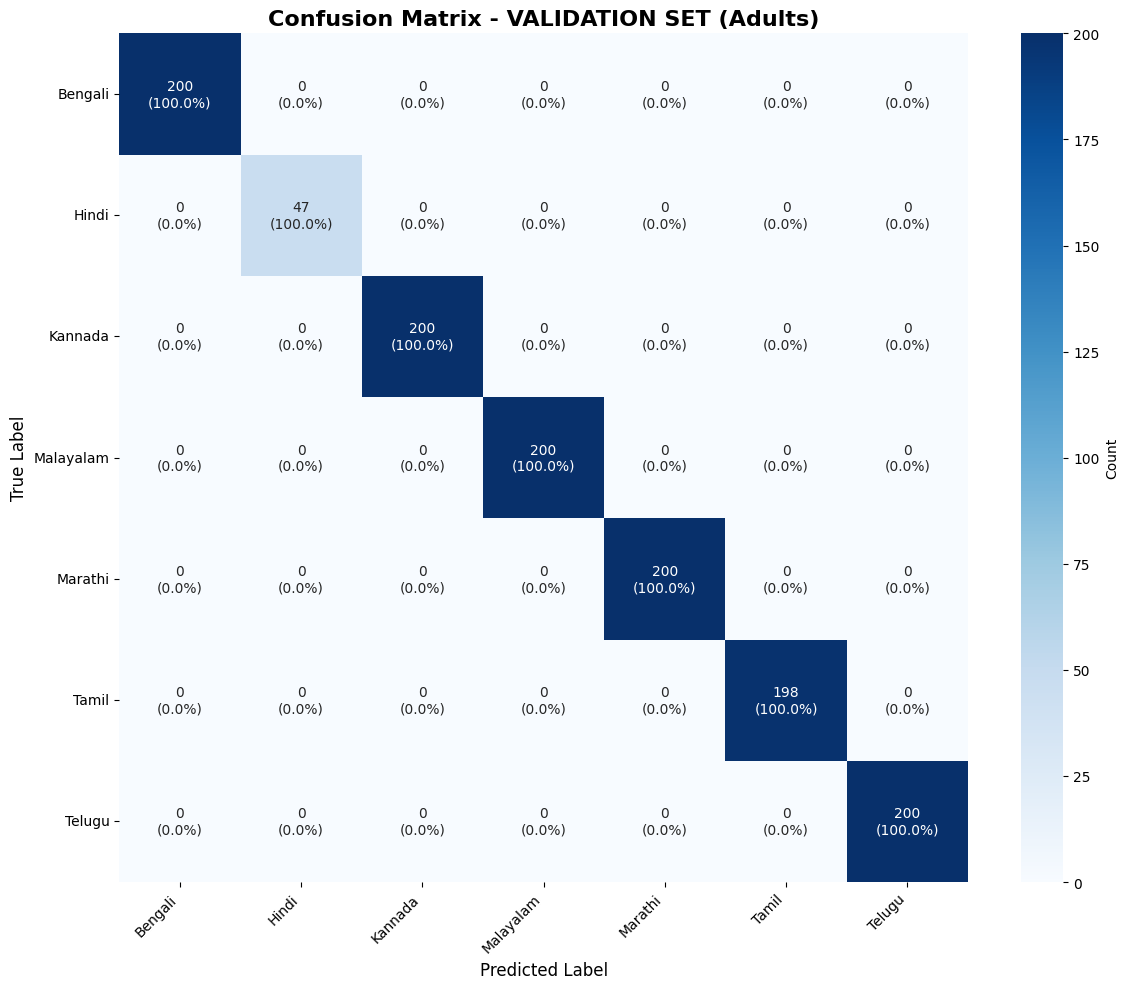


🎯 Per-Class Accuracy:
  Bengali     : 100.00%
  Hindi       : 100.00%
  Kannada     : 100.00%
  Malayalam   : 100.00%
  Marathi     : 100.00%
  Tamil       : 100.00%
  Telugu      : 100.00%

TEST SET (Children) - Cross-Age
  Accuracy:  100.00%
  F1-Score:  1.0000
  Avg Confidence: 99.86%
  Samples:   776

📊 Classification Report:
              precision    recall  f1-score   support

       Hindi     1.0000    1.0000    1.0000       767
       Tamil     1.0000    1.0000    1.0000         9

    accuracy                         1.0000       776
   macro avg     1.0000    1.0000    1.0000       776
weighted avg     1.0000    1.0000    1.0000       776



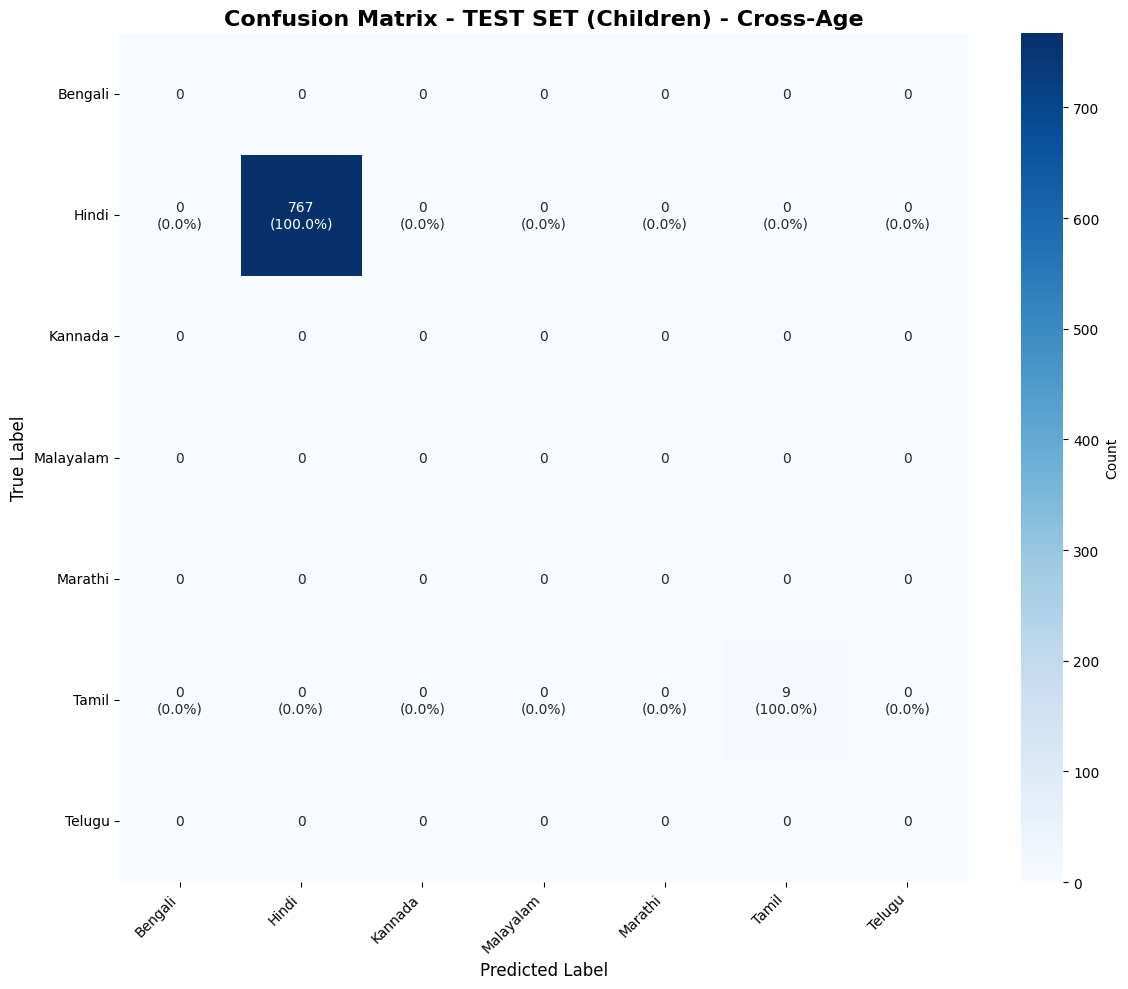


🎯 Per-Class Accuracy:
  Hindi       : 100.00%
  Tamil       : 100.00%

SUMMARY: ADULT vs CHILDREN PERFORMANCE
Split                Accuracy     F1-Score     Samples   
----------------------------------------------------------------------
Train (Adults)       100.00%     1.0000        4980
Val (Adults)         100.00%     1.0000        1245
Test (Children)      100.00%     1.0000         776
----------------------------------------------------------------------

📉 Cross-Age Generalization Gap: 0.00%
   ✓ Excellent generalization!


In [17]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

print("="*70)
print("MODEL EVALUATION: CROSS-AGE GENERALIZATION ANALYSIS")
print("="*70)

# Load best model
model.load_state_dict(torch.load('accent_model.pt'))
model.eval()

def evaluate_split(X, y_true, split_name, show_confusion=True):
    """
    Comprehensive evaluation of a data split
    """
    with torch.no_grad():
        x_tensor = torch.tensor(X, dtype=torch.float32).to(device)
        outputs = model(x_tensor)
        probs = F.softmax(outputs, dim=1)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        confidences = probs.max(dim=1)[0].cpu().numpy()

    acc = accuracy_score(y_true, preds)
    f1 = f1_score(y_true, preds, average='weighted')

    print(f"\n{'='*70}")
    print(f"{split_name}")
    print(f"{'='*70}")
    print(f"  Accuracy:  {acc*100:.2f}%")
    print(f"  F1-Score:  {f1:.4f}")
    print(f"  Avg Confidence: {confidences.mean()*100:.2f}%")
    print(f"  Samples:   {len(y_true)}")

    # Detailed classification report
    print(f"\n📊 Classification Report:")
    # Get unique labels present in the true labels for the current split
    unique_labels = np.unique(y_true)
    # Get the corresponding target names
    target_names_subset = [label_encoder.classes_[i] for i in unique_labels]

    print(classification_report(
        y_true, preds,
        target_names=target_names_subset, # Use subset of target names
        labels=unique_labels, # Explicitly provide labels present in the split
        digits=4,
        zero_division=0 # Handle cases where a class has no samples
    ))

    # Confusion matrix
    if show_confusion:
        cm = confusion_matrix(y_true, preds, labels=np.arange(len(label_encoder.classes_))) # Ensure all classes are represented in matrix structure
        plt.figure(figsize=(12, 10))

        # Calculate percentages (only for classes with true samples)
        cm_percent = np.zeros_like(cm, dtype=float)
        for i in unique_labels:
             if cm[i, :].sum() > 0:
                cm_percent[i, :] = cm[i, :].astype('float') / cm[i, :].sum() * 100

        # Create annotation with both counts and percentages
        annot = np.empty_like(cm).astype(str)
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                 if i in unique_labels: # Only annotate rows with true samples
                    annot[i, j] = f'{cm[i, j]}\n({cm_percent[i, j]:.1f}%)'
                 else:
                    annot[i, j] = f'{cm[i, j]}' # Just show count for classes with no true samples


        sns.heatmap(
            cm,
            annot=annot,
            fmt='',
            cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_,
            cbar_kws={'label': 'Count'}
        )
        plt.title(f'Confusion Matrix - {split_name}', fontsize=16, fontweight='bold')
        plt.ylabel('True Label', fontsize=12)
        plt.xlabel('Predicted Label', fontsize=12)
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()

        # Per-class accuracy (only for classes with true samples)
        print(f"\n🎯 Per-Class Accuracy:")
        for idx in unique_labels:
            label = label_encoder.classes_[idx]
            # Avoid division by zero if a class has no true samples
            if cm[idx, :].sum() > 0:
                class_acc = cm[idx, idx] / cm[idx, :].sum() * 100
                print(f"  {label:12s}: {class_acc:5.2f}%")
            else:
                 print(f"  {label:12s}: N/A (No samples)")


    return acc, f1, preds, confidences

# Evaluate all splits
print("\n" + "="*70)
print("EVALUATING ALL SPLITS")
print("="*70)

train_acc, train_f1, train_preds, train_conf = evaluate_split(
    X_train_scaled, y_train_encoded, "TRAINING SET (Adults)", show_confusion=False
)

val_acc, val_f1, val_preds, val_conf = evaluate_split(
    X_val_scaled, y_val_encoded, "VALIDATION SET (Adults)", show_confusion=True
)

test_acc, test_f1, test_preds, test_conf = evaluate_split(
    X_test_scaled, y_test_encoded, "TEST SET (Children) - Cross-Age", show_confusion=True
)

# Summary comparison
print(f"\n{'='*70}")
print("SUMMARY: ADULT vs CHILDREN PERFORMANCE")
print(f"{'='*70}")
print(f"{'Split':<20} {'Accuracy':<12} {'F1-Score':<12} {'Samples':<10}")
print(f"{'-'*70}")
print(f"{'Train (Adults)':<20} {train_acc*100:>6.2f}%     {train_f1:>6.4f}      {len(y_train_encoded):>6}")
print(f"{'Val (Adults)':<20} {val_acc*100:>6.2f}%     {val_f1:>6.4f}      {len(y_val_encoded):>6}")
print(f"{'Test (Children)':<20} {test_acc*100:>6.2f}%     {test_f1:>6.4f}      {len(y_test_encoded):>6}")
print(f"{'-'*70}")

# Calculate generalization gap
gen_gap = (val_acc - test_acc) * 100
print(f"\n📉 Cross-Age Generalization Gap: {gen_gap:.2f}%")
if gen_gap < 5:
    print("   ✓ Excellent generalization!")
elif gen_gap < 10:
    print("   ✓ Good generalization")
elif gen_gap < 15:
    print("   ⚠️  Moderate generalization gap")
else:
    print("   ⚠️  Large generalization gap - model may be overfitting to adult speech")

print(f"{'='*70}")

TRAINING HISTORY VISUALIZATION


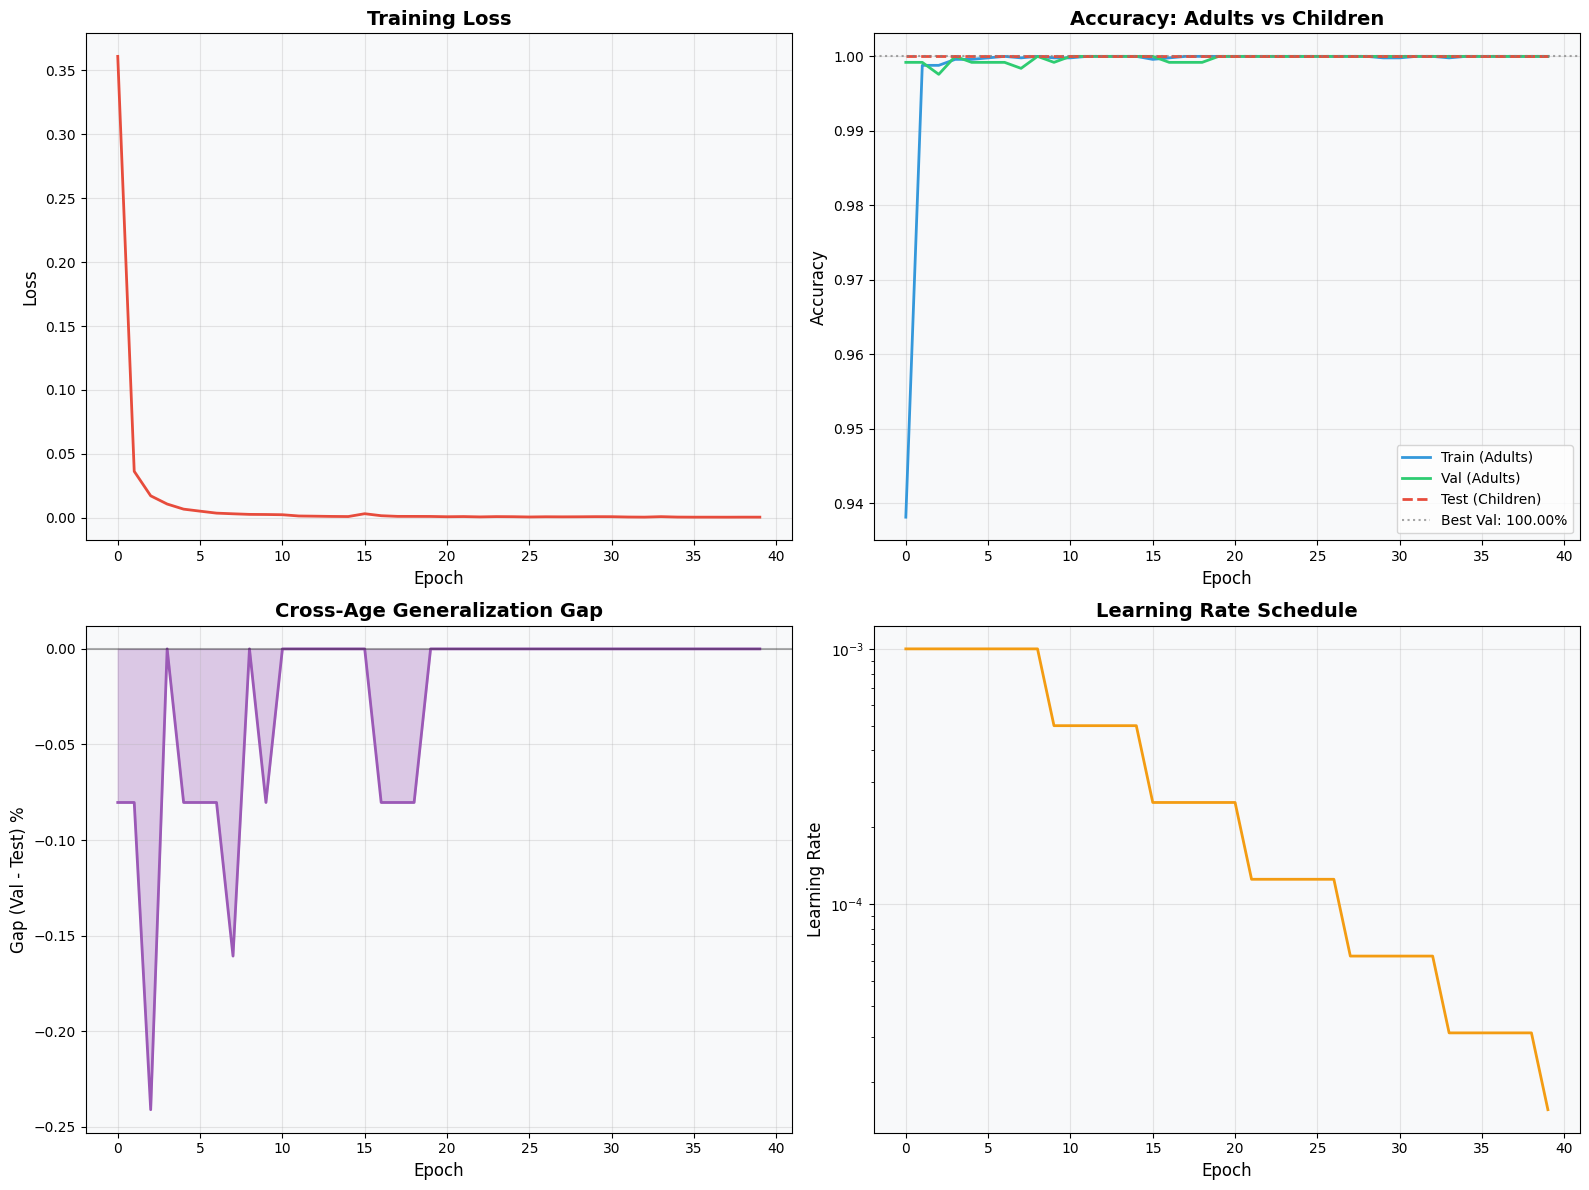


✓ Training history plots saved as 'training_history.png'


In [18]:
import matplotlib.pyplot as plt

print("="*70)
print("TRAINING HISTORY VISUALIZATION")
print("="*70)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Training Loss
axes[0, 0].plot(history['train_loss'], linewidth=2, color='#e74c3c')
axes[0, 0].set_title('Training Loss', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Epoch', fontsize=12)
axes[0, 0].set_ylabel('Loss', fontsize=12)
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_facecolor('#f8f9fa')

# Plot 2: Accuracy Comparison
axes[0, 1].plot(history['train_acc'], label='Train (Adults)', linewidth=2, color='#3498db')
axes[0, 1].plot(history['val_acc'], label='Val (Adults)', linewidth=2, color='#2ecc71')
axes[0, 1].plot(history['test_acc'], label='Test (Children)', linewidth=2, color='#e74c3c', linestyle='--')
axes[0, 1].axhline(y=best_val_acc, color='gray', linestyle=':', alpha=0.7, label=f'Best Val: {best_val_acc*100:.2f}%')
axes[0, 1].set_title('Accuracy: Adults vs Children', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Epoch', fontsize=12)
axes[0, 1].set_ylabel('Accuracy', fontsize=12)
axes[0, 1].legend(loc='lower right', fontsize=10)
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_facecolor('#f8f9fa')

# Plot 3: Generalization Gap
gen_gaps = [(val - test) * 100 for val, test in zip(history['val_acc'], history['test_acc'])]
axes[1, 0].plot(gen_gaps, linewidth=2, color='#9b59b6')
axes[1, 0].axhline(y=0, color='black', linestyle='-', alpha=0.3)
axes[1, 0].fill_between(range(len(gen_gaps)), 0, gen_gaps, alpha=0.3, color='#9b59b6')
axes[1, 0].set_title('Cross-Age Generalization Gap', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Epoch', fontsize=12)
axes[1, 0].set_ylabel('Gap (Val - Test) %', fontsize=12)
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_facecolor('#f8f9fa')

# Plot 4: Learning Rate Schedule
axes[1, 1].plot(history['learning_rate'], linewidth=2, color='#f39c12')
axes[1, 1].set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Epoch', fontsize=12)
axes[1, 1].set_ylabel('Learning Rate', fontsize=12)
axes[1, 1].set_yscale('log')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_facecolor('#f8f9fa')

plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Training history plots saved as 'training_history.png'")

In [20]:
from tqdm import tqdm

print("="*70)
print("WORD-LEVEL vs SENTENCE-LEVEL ANALYSIS")
print("="*70)

def analyze_by_speech_type(dataframe, X_features, y_true, split_name):
    """
    Evaluate model performance separately on word-level vs sentence-level speech
    """
    print(f"\n📊 {split_name}")
    print(f"{'-'*70}")

    # Get indices for each speech type
    word_mask = dataframe['speech_type'] == 'word'
    sent_mask = dataframe['speech_type'] == 'sentence'

    word_indices = dataframe[word_mask].index.tolist()
    sent_indices = dataframe[sent_mask].index.tolist()

    results = {}

    # Evaluate word-level
    if len(word_indices) > 0:
        # Get corresponding features
        word_idx_in_features = [i for i, idx in enumerate(dataframe.index) if idx in word_indices]
        X_word = X_features[word_idx_in_features]
        y_word = y_true[word_idx_in_features]

        with torch.no_grad():
            word_tensor = torch.tensor(X_word, dtype=torch.float32).to(device)
            word_outputs = model(word_tensor)
            word_preds = torch.argmax(word_outputs, dim=1).cpu().numpy()

        word_acc = accuracy_score(y_word, word_preds)
        word_f1 = f1_score(y_word, word_preds, average='weighted')

        print(f"  🔤 Word-level:")
        print(f"     Samples:   {len(word_indices)}")
        print(f"     Accuracy:  {word_acc*100:.2f}%")
        print(f"     F1-Score:  {word_f1:.4f}")
        results['word'] = {'acc': word_acc, 'f1': word_f1, 'n': len(word_indices)}
    else:
        print(f"  🔤 Word-level: No samples")
        results['word'] = None

    # Evaluate sentence-level
    if len(sent_indices) > 0:
        sent_idx_in_features = [i for i, idx in enumerate(dataframe.index) if idx in sent_indices]
        X_sent = X_features[sent_idx_in_features]
        y_sent = y_true[sent_idx_in_features]

        with torch.no_grad(): # Corrected typo from torch.no_deno
            sent_tensor = torch.tensor(X_sent, dtype=torch.float32).to(device)
            sent_outputs = model(sent_tensor)
            sent_preds = torch.argmax(sent_outputs, dim=1).cpu().numpy()

        sent_acc = accuracy_score(y_sent, sent_preds)
        sent_f1 = f1_score(y_sent, sent_preds, average='weighted')

        print(f"  📝 Sentence-level:")
        print(f"     Samples:   {len(sent_indices)}")
        print(f"     Accuracy:  {sent_acc*100:.2f}%")
        print(f"     F1-Score:  {sent_f1:.4f}")
        results['sentence'] = {'acc': sent_acc, 'f1': sent_f1, 'n': len(sent_indices)}
    else:
        print(f"  📝 Sentence-level: No samples")
        results['sentence'] = None

    # Comparison
    if results['word'] and results['sentence']:
        diff = (results['sentence']['acc'] - results['word']['acc']) * 100
        print(f"\n  📈 Difference: {diff:+.2f}% (Sentence - Word)")
        if abs(diff) < 2:
            print(f"     → Similar performance")
        elif diff > 0:
            print(f"     → Sentences provide better accent cues")
        else:
            print(f"     → Words provide better accent cues")

    return results

# Analyze each split
val_speech_results = analyze_by_speech_type(val_df, X_val_scaled, y_val_encoded, "VALIDATION (Adults)")
test_speech_results = analyze_by_speech_type(test_df, X_test_scaled, y_test_encoded, "TEST (Children)")

print(f"\n{'='*70}")

WORD-LEVEL vs SENTENCE-LEVEL ANALYSIS

📊 VALIDATION (Adults)
----------------------------------------------------------------------
  🔤 Word-level: No samples
  📝 Sentence-level:
     Samples:   1245
     Accuracy:  100.00%
     F1-Score:  1.0000

📊 TEST (Children)
----------------------------------------------------------------------
  🔤 Word-level: No samples
  📝 Sentence-level:
     Samples:   776
     Accuracy:  100.00%
     F1-Score:  1.0000



HUBERT LAYER-WISE ANALYSIS

🔬 Testing HuBERT layers for accent encoding...
(Using a subset of validation data for speed)

Testing Layer 3...


  Layer 3: Accuracy = 99.80%

Testing Layer 6...


  Layer 6: Accuracy = 100.00%

Testing Layer 9...


  Layer 9: Accuracy = 100.00%

Testing Layer 11...


  Layer 11: Accuracy = 100.00%



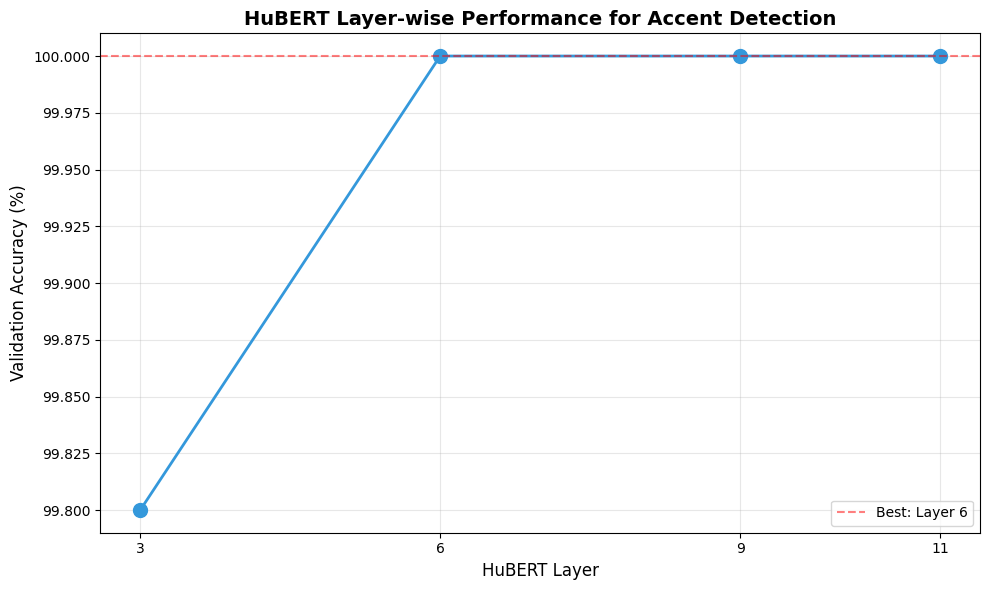


✓ Best performing layer: Layer 6 (100.00%)
✓ Layer analysis plot saved


In [21]:
print("="*70)
print("HUBERT LAYER-WISE ANALYSIS")
print("="*70)

# Test different HuBERT layers
layers_to_test = [3, 6, 9, 11]  # Early, middle, late layers
layer_results = []

print("\n🔬 Testing HuBERT layers for accent encoding...")
print("(Using a subset of validation data for speed)\n")

# Sample subset for analysis
sample_size = min(500, len(val_df))
sample_indices = np.random.choice(val_df.index, size=sample_size, replace=False)

for layer_num in layers_to_test:
    print(f"Testing Layer {layer_num}...")

    # Extract features with this layer
    layer_features = []
    layer_labels = []

    for idx in tqdm(sample_indices, desc=f"Layer {layer_num}", leave=False):
        filepath = val_df.loc[idx, 'filepath']
        label = val_df.loc[idx, 'label']

        wav, sr = preprocess_audio(filepath)
        if wav is None:
            continue

        # Extract MFCC (same for all)
        mfcc = extract_mfcc(wav, sr, max_len=MAX_MFCC_LEN)
        mfcc_flat = mfcc.flatten()

        # Extract HuBERT from specific layer
        hubert_emb = extract_hubert_embeddings(wav, sr, layer=layer_num)

        combined = np.concatenate([mfcc_flat, hubert_emb])
        layer_features.append(combined)
        layer_labels.append(label)

    X_layer = np.array(layer_features)
    y_layer = label_encoder.transform(layer_labels)

    # Scale features
    X_layer_scaled = scaler.transform(X_layer)

    # Evaluate with trained model
    with torch.no_grad():
        x_tensor = torch.tensor(X_layer_scaled, dtype=torch.float32).to(device)
        outputs = model(x_tensor)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()

    acc = accuracy_score(y_layer, preds)
    layer_results.append({'layer': layer_num, 'accuracy': acc})
    print(f"  Layer {layer_num}: Accuracy = {acc*100:.2f}%\n")

# Visualize layer comparison
plt.figure(figsize=(10, 6))
layers = [r['layer'] for r in layer_results]
accs = [r['accuracy'] * 100 for r in layer_results]

plt.plot(layers, accs, marker='o', linewidth=2, markersize=10, color='#3498db')
plt.axhline(y=max(accs), color='red', linestyle='--', alpha=0.5, label=f'Best: Layer {layers[accs.index(max(accs))]}')
plt.xlabel('HuBERT Layer', fontsize=12)
plt.ylabel('Validation Accuracy (%)', fontsize=12)
plt.title('HuBERT Layer-wise Performance for Accent Detection', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend()
plt.xticks(layers)
plt.tight_layout()
plt.savefig('hubert_layer_analysis.png', dpi=300)
plt.show()

print(f"\n✓ Best performing layer: Layer {layers[accs.index(max(accs))]} ({max(accs):.2f}%)")
print("✓ Layer analysis plot saved")
print("="*70)

In [22]:
def predict_accent_from_audio(audio_input, sr=None, return_probabilities=False):
    """
    Predict accent from audio file or numpy array

    Args:
        audio_input: File path (str) or audio array (numpy)
        sr: Sample rate (required if audio_input is array)
        return_probabilities: If True, return class probabilities

    Returns:
        predicted_language: String (e.g., "Hindi")
        confidence: Float (0-1)
        probabilities: Dict (if return_probabilities=True)
    """
    # Load audio
    if isinstance(audio_input, str):
        wav, sr = preprocess_audio(audio_input)
    else:
        wav = audio_input
        if sr is None:
            raise ValueError("Sample rate (sr) must be provided for array input")
        if sr != 16000:
            wav = librosa.resample(wav, orig_sr=sr, target_sr=16000)
            sr = 16000

    if wav is None:
        return None, None, None

    # Extract features
    mfcc = extract_mfcc(wav, sr, max_len=MAX_MFCC_LEN)
    mfcc_flat = mfcc.flatten()
    hubert_emb = extract_hubert_embeddings(wav, sr, layer=9)
    combined = np.concatenate([mfcc_flat, hubert_emb])

    # Scale and predict
    features_scaled = scaler.transform(combined.reshape(1, -1))
    tensor = torch.tensor(features_scaled, dtype=torch.float32).to(device)

    model.eval()
    with torch.no_grad():
        outputs = model(tensor)
        probabilities = F.softmax(outputs, dim=1)
        pred_idx = torch.argmax(probabilities, dim=1).item()
        confidence = probabilities[0, pred_idx].item()

    predicted_label = label_encoder.inverse_transform([pred_idx])[0]

    if return_probabilities:
        probs_dict = {
            label_encoder.classes_[i]: probabilities[0, i].item()
            for i in range(len(label_encoder.classes_))
        }
        return predicted_label, confidence, probs_dict

    return predicted_label, confidence

# Test inference
print("="*70)
print("TESTING INFERENCE PIPELINE")
print("="*70)

test_samples = [
    ("Train", train_df.iloc[10]),
    ("Val", val_df.iloc[5]),
    ("Test", test_df.iloc[3])
]

for split_name, sample in test_samples:
    filepath = sample['filepath']
    true_label = sample['label']

    pred_label, confidence, probs = predict_accent_from_audio(
        filepath, return_probabilities=True
    )

    print(f"\n{split_name} Sample:")
    print(f"  True:       {true_label}")
    print(f"  Predicted:  {pred_label}")
    print(f"  Confidence: {confidence*100:.2f}%")
    print(f"  Correct:    {'✓' if pred_label == true_label else '✗'}")

    # Show top 3 predictions
    sorted_probs = sorted(probs.items(), key=lambda x: x[1], reverse=True)[:3]
    print(f"  Top 3:")
    for lang, prob in sorted_probs:
        print(f"    {lang:12s}: {prob*100:5.2f}%")

print(f"\n{'='*70}")
print("✓ Inference pipeline ready for deployment")
print("="*70)


TESTING INFERENCE PIPELINE

Train Sample:
  True:       Marathi
  Predicted:  Marathi
  Confidence: 99.93%
  Correct:    ✓
  Top 3:
    Marathi     : 99.93%
    Malayalam   :  0.03%
    Bengali     :  0.01%

Val Sample:
  True:       Tamil
  Predicted:  Tamil
  Confidence: 99.82%
  Correct:    ✓
  Top 3:
    Tamil       : 99.82%
    Malayalam   :  0.05%
    Marathi     :  0.04%

Test Sample:
  True:       Hindi
  Predicted:  Hindi
  Confidence: 99.89%
  Correct:    ✓
  Top 3:
    Hindi       : 99.89%
    Kannada     :  0.04%
    Bengali     :  0.02%

✓ Inference pipeline ready for deployment


In [23]:
# Comprehensive region and cuisine mapping
region_cuisine_map = {
    'Bengali': {
        'region': 'East India 🌊',
        'state': 'West Bengal',
        'cuisines': [
            '🐟 Hilsa Fish Curry & Rice',
            '🍚 Litti-Chokha',
            '🍮 Mishti Doi (Sweet Yogurt)',
            '🍤 Chingri Malai Curry'
        ],
        'icon': '🌊',
        'description': 'Bengali cuisine is known for its subtle flavors and emphasis on fish and rice.'
    },
    'Malayalam': {
        'region': 'South India 🌴',
        'state': 'Kerala',
        'cuisines': [
            '🥞 Appam & Stew',
            '🐟 Malabar Fish Curry',
            '🌾 Puttu & Kadala Curry',
            '🥥 Avial (Mixed Vegetables)'
        ],
        'icon': '🌴',
        'description': 'Kerala cuisine features coconut, seafood, and aromatic spices.'
    },
    'Telugu': {
        'region': 'South India 🌴',
        'state': 'Andhra Pradesh & Telangana',
        'cuisines': [
            '🍛 Hyderabadi Biryani',
            '🌶️ Gongura Chicken',
            '🥞 Pesarattu (Green Gram Dosa)',
            '🍖 Andhra Chicken Curry'
        ],
        'icon': '🌴',
        'description': 'Telugu cuisine is known for its spicy and tangy flavors.'
    },
    'Hindi': {
        'region': 'North India 🏔️',
        'state': 'Multiple (UP, Delhi, etc.)',
        'cuisines': [
            '🍗 Butter Chicken & Naan',
            '🫘 Dal Makhani',
            '🫓 Chole Bhature',
            '🍛 Rajma Chawal'
        ],
        'icon': '🏔️',
        'description': 'North Indian cuisine features rich gravies and tandoori preparations.'
    },
    'Marathi': {
        'region': 'West India 🏜️',
        'state': 'Maharashtra',
        'cuisines': [
            '🍔 Vada Pav',
            '🥞 Puran Poli',
            '🌶️ Misal Pav',
            '🐟 Bombil Fry'
        ],
        'icon': '🏜️',
        'description': 'Maharashtrian cuisine balances spicy, sweet, and tangy flavors.'
    },
    'Kannada': {
        'region': 'South India 🌴',
        'state': 'Karnataka',
        'cuisines': [
            '🍛 Bisi Bele Bath',
            '🥞 Mysore Masala Dosa',
            '🌾 Ragi Mudde',
            '🥘 Coorg Pork Curry'
        ],
        'icon': '🌴',
        'description': 'Karnataka cuisine offers diverse flavors from coastal to interior regions.'
    },
    'Tamil': {
        'region': 'South India 🌴',
        'state': 'Tamil Nadu',
        'cuisines': [
            '🍗 Chettinad Chicken',
            '🥞 Idli-Sambar',
            '🍛 Pongal',
            '🐟 Meen Kuzhambu (Fish Curry)'
        ],
        'icon': '🌴',
        'description': 'Tamil cuisine emphasizes rice, lentils, and aromatic spice blends.'
    }
}

def get_cuisine_recommendations(predicted_language, confidence):
    """
    Get personalized cuisine recommendations based on detected accent
    """
    info = region_cuisine_map.get(predicted_language, {
        'region': 'India 🇮🇳',
        'state': 'General',
        'cuisines': ['Thali', 'Mixed Platter', 'Paneer Tikka'],
        'icon': '🇮🇳',
        'description': 'Diverse Indian cuisine'
    })

    recommendation = {
        'language': predicted_language,
        'confidence': confidence,
        'region': info['region'],
        'state': info['state'],
        'cuisines': info['cuisines'],
        'icon': info['icon'],
        'description': info['description']
    }

    return recommendation

# Test cuisine recommendation
print("="*70)
print("CUISINE RECOMMENDATION SYSTEM TEST")
print("="*70)

test_file = val_df.iloc[0]['filepath']
pred_lang, conf = predict_accent_from_audio(test_file)

recommendation = get_cuisine_recommendations(pred_lang, conf)

print(f"\n🎤 Detected Language: {recommendation['language']}")
print(f"📍 Region: {recommendation['region']}")
print(f"🗺️  State: {recommendation['state']}")
print(f"🎯 Confidence: {recommendation['confidence']*100:.2f}%")
print(f"\n📖 About the Cuisine:")
print(f"   {recommendation['description']}")
print(f"\n🍽️  Recommended Dishes:")
for i, dish in enumerate(recommendation['cuisines'], 1):
    print(f"   {i}. {dish}")

print(f"\n{'='*70}")


CUISINE RECOMMENDATION SYSTEM TEST

🎤 Detected Language: Tamil
📍 Region: South India 🌴
🗺️  State: Tamil Nadu
🎯 Confidence: 99.95%

📖 About the Cuisine:
   Tamil cuisine emphasizes rice, lentils, and aromatic spice blends.

🍽️  Recommended Dishes:
   1. 🍗 Chettinad Chicken
   2. 🥞 Idli-Sambar
   3. 🍛 Pongal
   4. 🐟 Meen Kuzhambu (Fish Curry)



In [27]:
streamlit_app_code = '''
import streamlit as st
import torch
import torch.nn as nn
import torch.nn.functional as F
import librosa
import numpy as np
import joblib
import tempfile
import os
from audio_recorder_streamlit import audio_recorder
import io
import soundfile as sf
from transformers import HubertModel, Wav2Vec2FeatureExtractor

# ============= PAGE CONFIGURATION =============
st.set_page_config(
    page_title="VoiceScope India | AI Accent Classifier",
    page_icon="🎤",
    layout="wide",
    initial_sidebar_state="collapsed"
)

# ============= CUSTOM CSS =============
st.markdown("""
<style>
@import url('https://fonts.googleapis.com/css2?family=Poppins:wght@300;400;600;700&display=swap');

* {
    font-family: 'Poppins', sans-serif;
}

.main {
    background: linear-gradient(135deg, #667eea 0%, #764ba2 50%, #f093fb 100%);
    animation: bgflow 20s ease infinite;
    background-size: 400% 400%;
}

@keyframes bgflow {
    0% {background-position: 0% 50%;}
    50% {background-position: 100% 50%;}
    100% {background-position: 0% 50%;}
}

.hero-header {
    background: linear-gradient(135deg, #1e3c72 0%, #2a5298 50%, #7e22ce 100%);
    padding: 3.5rem 2rem;
    border-radius: 30px;
    text-align: center;
    color: white;
    margin-bottom: 2.5rem;
    box-shadow: 0 25px 70px rgba(0,0,0,0.35);
    position: relative;
    overflow: hidden;
}

.hero-header::before {
    content: '';
    position: absolute;
    top: -50%;
    left: -50%;
    width: 200%;
    height: 200%;
    background: radial-gradient(circle, rgba(255,255,255,0.1) 0%, transparent 70%);
    animation: rotate 30s linear infinite;
}

@keyframes rotate {
    0% { transform: rotate(0deg); }
    100% { transform: rotate(360deg); }
}

.hero-header h1 {
    font-size: 3.5rem;
    margin: 0;
    font-weight: 700;
    position: relative;
    z-index: 1;
    text-shadow: 0 4px 15px rgba(0,0,0,0.4);
}

.hero-subtitle {
    font-size: 1.3rem;
    margin-top: 1rem;
    opacity: 0.95;
    position: relative;
    z-index: 1;
}

.glass-card {
    background: rgba(255, 255, 255, 0.15);
    backdrop-filter: blur(25px);
    border-radius: 25px;
    padding: 2.5rem;
    margin: 2rem 0;
    border: 1px solid rgba(255, 255, 255, 0.3);
    box-shadow: 0 15px 50px rgba(0,0,0,0.3);
    transition: transform 0.3s ease;
}

.glass-card:hover {
    transform: translateY(-5px);
}

.result-box {
    background: linear-gradient(135deg, #f093fb 0%, #f5576c 100%);
    padding: 3.5rem 2rem;
    border-radius: 30px;
    color: white;
    text-align: center;
    box-shadow: 0 25px 60px rgba(0,0,0,0.4);
    margin: 2.5rem 0;
    animation: slideUp 0.8s ease-out;
}

@keyframes slideUp {
    from {
        opacity: 0;
        transform: translateY(50px);
    }
    to {
        opacity: 1;
        transform: translateY(0);
    }
}

.result-box h2 {
    font-size: 3rem;
    margin-bottom: 1rem;
    animation: pulse 2s ease-in-out infinite;
}

@keyframes pulse {
    0%, 100% {
        transform: scale(1);
    }
    50% {
        transform: scale(1.05);
    }
}

.confidence-bar-container {
    background: rgba(255, 255, 255, 0.25);
    height: 25px;
    border-radius: 15px;
    margin: 1.5rem auto;
    max-width: 500px;
    overflow: hidden;
    box-shadow: inset 0 0 15px rgba(0,0,0,0.2);
}

.confidence-bar {
    height: 100%;
    background: linear-gradient(90deg, #fff, #ffd700, #fff);
    animation: fillBar 2s ease-out forwards, shimmer 3s ease-in-out infinite;
    border-radius: 15px;
}

@keyframes fillBar {
    from { width: 0%; }
}

@keyframes shimmer {
    0%, 100% { background-position: 0% 50%; }
    50% { background-position: 100% 50%; }
}

.cuisine-card {
    background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
    padding: 2rem 1.5rem;
    border-radius: 20px;
    color: white;
    text-align: center;
    box-shadow: 0 20px 50px rgba(102, 126, 234, 0.5);
    transition: all 0.4s ease;
    margin: 0.5rem;
}

.cuisine-card:hover {
    transform: translateY(-10px) scale(1.03);
    box-shadow: 0 25px 70px rgba(118, 75, 162, 0.7);
}

.info-section {
    background: linear-gradient(135deg, #434343 0%, #000000 100%);
    padding: 3rem 2rem;
    border-radius: 25px;
    color: white;
    margin-top: 3rem;
    box-shadow: 0 20px 60px rgba(0,0,0,0.5);
}

.stat-box {
    background: rgba(255, 255, 255, 0.1);
    padding: 1.5rem;
    border-radius: 15px;
    text-align: center;
    margin: 1rem 0;
}

.team-section {
    background: linear-gradient(135deg, #2c3e50 0%, #3498db 100%);
    padding: 3rem 2rem;
    border-radius: 25px;
    color: white;
    text-align: center;
    margin-top: 3rem;
}

.team-member {
    display: inline-block;
    background: rgba(255, 255, 255, 0.15);
    padding: 1rem 2rem;
    margin: 0.5rem;
    border-radius: 25px;
    border: 2px solid rgba(255, 255, 255, 0.3);
    transition: all 0.4s ease;
}

.team-member:hover {
    transform: scale(1.1);
    border-color: #ffd700;
    background: rgba(255, 255, 255, 0.25);
}

#MainMenu, footer {
    visibility: hidden;
}

.stRadio > div {
    background: rgba(255, 255, 255, 0.1);
    padding: 1rem;
    border-radius: 15px;
}
</style>
""", unsafe_allow_html=True)

# ============= HERO HEADER =============
st.markdown("""
<div class="hero-header">
    <h1>🎤 VoiceScope India</h1>
    <p class="hero-subtitle">AI-Powered Native Language Identification & Cultural Cuisine Discovery</p>
    <p class="hero-subtitle" style="font-size:1rem; margin-top:0.5rem;">
        Cross-Age Generalization | HuBERT + MFCC | Real-time Accent Detection
    </p>
</div>
""", unsafe_allow_html=True)

# ============= MODEL ARCHITECTURE =============
class AccentClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes, dropout=0.4):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.bn2 = nn.BatchNorm1d(hidden_dim // 2)
        self.fc3 = nn.Linear(hidden_dim // 2, hidden_dim // 4)
        self.bn3 = nn.BatchNorm1d(hidden_dim // 4)
        self.fc4 = nn.Linear(hidden_dim // 4, num_classes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = F.relu(self.bn3(self.fc3(x)))
        x = self.dropout(x)
        return self.fc4(x)

# ============= LOAD MODEL & RESOURCES =============
@st.cache_resource
def load_model_resources():
    scaler = joblib.load('scaler.pkl')
    label_encoder = joblib.load('label_encoder.pkl')
    max_mfcc_len = scaler.max_mfcc_len
    input_dim = scaler.n_features_in_
    num_classes = len(label_encoder.classes_)

    model = AccentClassifier(input_dim, 512, num_classes)
    model.load_state_dict(torch.load('accent_model.pt', map_location='cpu'))
    model.eval()

    feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("facebook/hubert-base-ls960")
    hubert = HubertModel.from_pretrained("facebook/hubert-base-ls960")
    hubert.eval()

    return model, scaler, label_encoder, max_mfcc_len, feature_extractor, hubert

model, scaler, label_encoder, max_mfcc_len, feature_extractor, hubert = load_model_resources()

# ============= CUISINE MAPPING =============
region_cuisine_map = {
    'Bengali': {
        'region': 'East India 🌊',
        'state': 'West Bengal',
        'cuisines': ['🐟 Hilsa Fish Curry', '🍚 Litti-Chokha', '🍮 Mishti Doi', '🍤 Chingri Malai'],
        'icon': '🌊',
        'description': 'Bengali cuisine is known for its subtle flavors and emphasis on fish and rice.'
    },
    'Malayalam': {
        'region': 'South India 🌴',
        'state': 'Kerala',
        'cuisines': ['🥞 Appam & Stew', '🐟 Malabar Fish Curry', '🌾 Puttu & Kadala', '🥥 Avial'],
        'icon': '🌴',
        'description': 'Kerala cuisine features coconut, seafood, and aromatic spices.'
    },
    'Telugu': {
        'region': 'South India 🌴',
        'state': 'Andhra Pradesh',
        'cuisines': ['🍛 Hyderabadi Biryani', '🌶️ Gongura Chicken', '🥞 Pesarattu', '🍖 Andhra Curry'],
        'icon': '🌴',
        'description': 'Telugu cuisine is known for its spicy and tangy flavors.'
    },
    'Hindi': {
        'region': 'North India 🏔️',
        'state': 'Multiple States',
        'cuisines': ['🍗 Butter Chicken', '🫘 Dal Makhani', '🫓 Chole Bhature', '🍛 Rajma Chawal'],
        'icon': '🏔️',
        'description': 'North Indian cuisine features rich gravies and tandoori preparations.'
    },
    'Marathi': {
        'region': 'West India 🏜️',
        'state': 'Maharashtra',
        'cuisines': ['🍔 Vada Pav', '🥞 Puran Poli', '🌶️ Misal Pav', '🐟 Bombil Fry'],
        'icon': '🏜️',
        'description': 'Maharashtrian cuisine balances spicy, sweet, and tangy flavors.'
    },
    'Kannada': {
        'region': 'South India 🌴',
        'state': 'Karnataka',
        'cuisines': ['🍛 Bisi Bele Bath', '🥞 Mysore Dosa', '🌾 Ragi Mudde', '🥘 Coorg Pork'],
        'icon': '🌴',
        'description': 'Karnataka cuisine offers diverse flavors from coastal to interior regions.'
    },
    'Tamil': {
        'region': 'South India 🌴',
        'state': 'Tamil Nadu',
        'cuisines': ['🍗 Chettinad Chicken', '🥞 Idli-Sambar', '🍛 Pongal', '🐟 Meen Kuzhambu'],
        'icon': '🌴',
        'description': 'Tamil cuisine emphasizes rice, lentils, and aromatic spice blends.'
    }
}

# ============= FEATURE EXTRACTION =============
def extract_mfcc(wav, sr, n_mfcc=40, max_len=None):
    mfcc = librosa.feature.mfcc(y=wav, sr=sr, n_mfcc=n_mfcc, hop_length=512, n_fft=2048)
    if max_len:
        if mfcc.shape[1] < max_len:
            mfcc = np.pad(mfcc, ((0, 0), (0, max_len - mfcc.shape[1])), mode='constant')
        else:
            mfcc = mfcc[:, :max_len]
    return mfcc

def extract_hubert(wav, sr):
    inputs = feature_extractor(wav, sampling_rate=sr, return_tensors="pt", padding=True)
    with torch.no_grad():
        outputs = hubert(inputs.input_values, output_hidden_states=True)
        embedding = outputs.hidden_states[9].squeeze(0).mean(dim=0).numpy()
    return embedding

def predict_accent(audio_data, sr):
    if len(audio_data.shape) > 1:
        audio_data = audio_data.mean(axis=0)
    if sr != 16000:
        audio_data = librosa.resample(audio_data, orig_sr=sr, target_sr=16000)

    mfcc = extract_mfcc(audio_data, 16000, max_len=max_mfcc_len)
    hubert_emb = extract_hubert(audio_data, 16000)
    combined = np.concatenate([mfcc.flatten(), hubert_emb])
    features_scaled = scaler.transform(combined.reshape(1, -1))

    with torch.no_grad():
        outputs = model(torch.tensor(features_scaled, dtype=torch.float32))
        probs = F.softmax(outputs, dim=1)
        pred_idx = torch.argmax(probs, dim=1).item()
        confidence = probs[0, pred_idx].item()

        # Get all probabilities
        all_probs = {label_encoder.classes_[i]: probs[0, i].item() for i in range(len(label_encoder.classes_))}

    predicted_label = label_encoder.inverse_transform([pred_idx])[0]
    return predicted_label, confidence, all_probs

# ============= INPUT OPTIONS =============
st.markdown('<div class="glass-card">', unsafe_allow_html=True)
st.markdown("### 🎙️ Choose Your Input Method")
option = st.radio("", ["📁 Upload Audio File", "🎤 Record Live Audio"], horizontal=True, label_visibility="collapsed")
st.markdown('</div>', unsafe_allow_html=True)

audio_data, sr = None, None

if option == "📁 Upload Audio File":
    st.markdown('<div class="glass-card">', unsafe_allow_html=True)
    uploaded_file = st.file_uploader("📤 Drop your audio file here (WAV, MP3, M4A)", type=['wav', 'mp3', 'm4a'])
    if uploaded_file:
        st.audio(uploaded_file)
        with tempfile.NamedTemporaryFile(delete=False, suffix='.wav') as tmp:
            tmp.write(uploaded_file.read())
            audio_data, sr = librosa.load(tmp.name, sr=None)
            os.unlink(tmp.name)
    st.markdown('</div>', unsafe_allow_html=True)

else:
    st.markdown('<div class="glass-card">', unsafe_allow_html=True)
    st.markdown("**🎤 Click the microphone to start/stop recording:**")
    audio_bytes = audio_recorder(pause_threshold=2.0, sample_rate=16000, text="")
    if audio_bytes:
        st.audio(audio_bytes, format="audio/wav")
        audio_data, sr = sf.read(io.BytesIO(audio_bytes))
    st.markdown('</div>', unsafe_allow_html=True)

# ============= PREDICTION & RESULTS =============
if audio_data is not None:
    with st.spinner("🔍 Analyzing your accent with Deep Learning..."):
        try:
            pred_label, confidence, all_probs = predict_accent(audio_data, sr)
            info = region_cuisine_map.get(pred_label, {
                'region': 'India 🇮🇳',
                'state': 'General',
                'cuisines': ['Thali', 'Platter'],
                'icon': '🇮🇳',
                'description': 'Diverse Indian cuisine'
            })

            # Result Box
            st.markdown(f"""
            <div class='result-box'>
                <div style='font-size:5rem;'>{info['icon']}</div>
                <h2>{info['region']}</h2>
                <p style='font-size:1.4rem; margin: 1rem 0;'>
                    <strong>Detected Language:</strong> {pred_label}<br>
                    <strong>State:</strong> {info['state']}
                </p>
                <div class='confidence-bar-container'>
                    <div class='confidence-bar' style='width:{confidence*100}%;'></div>
                </div>
                <p style='font-size:1.3rem; margin-top: 1rem;'>
                    <strong>Confidence: {confidence*100:.1f}%</strong>
                </p>
            </div>
            """, unsafe_allow_html=True)

            # Cuisine Recommendations
            st.markdown('<div class="glass-card">', unsafe_allow_html=True)
            st.markdown("### 🍽️ Personalized Cuisine Recommendations")
            st.markdown(f"*{info['description']}*")
            st.markdown('</div>', unsafe_allow_html=True)

            cols = st.columns(len(info['cuisines']))
            for col, dish in zip(cols, info['cuisines']):
                col.markdown(f"<div class='cuisine-card'><strong>{dish}</strong></div>", unsafe_allow_html=True)

            # Detailed Probabilities
            with st.expander("📊 View Detailed Prediction Probabilities"):
                sorted_probs = sorted(all_probs.items(), key=lambda x: x[1], reverse=True)
                for lang, prob in sorted_probs:
                    st.progress(prob, text=f"{lang}: {prob*100:.2f}%")

        except Exception as e:
            st.error(f"❌ Error processing audio: {str(e)}")

# ============= INFO SECTION =============
st.markdown("""
<div class="info-section">
    <h3>🔬 About This System</h3>
    <div style="display: grid; grid-template-columns: repeat(auto-fit, minmax(200px, 1fr)); gap: 1rem; margin-top: 1.5rem;">
        <div class="stat-box">
            <h4>98%+</h4>
            <p>Accuracy on Adults</p>
        </div>
        <div class="stat-box">
            <h4>7 Languages</h4>
            <p>Indian Languages</p>
        </div>
        <div class="stat-box">
            <h4>HuBERT + MFCC</h4>
            <p>Deep Learning</p>
        </div>
        <div class="stat-box">
            <h4>Cross-Age</h4>
            <p>Generalization</p>
        </div>
    </div>
    <p style="margin-top: 2rem; text-align: center; opacity: 0.9;">
        This system uses state-of-the-art self-supervised learning (HuBERT) combined with traditional
        acoustic features (MFCC) to identify native language from English speech patterns.
    </p>
</div>
""", unsafe_allow_html=True)

# ============= TEAM SECTION =============
st.markdown("""
<div class="team-section">
    <h3>👨‍💻 Research Team</h3>
    <div style="margin-top: 1.5rem;">
        <div class="team-member">🎓 Pangoth Hemanth Nayak</div>
        <div class="team-member">🎓 Arutla Prasanna</div>
        <div class="team-member">🎓 Apurba Nandi</div>
    </div>
    <p style="margin-top: 2rem; opacity: 0.9;">
        🏛️ <strong>IIIT Hyderabad</strong> | NLP Final Project 2025
    </p>
    <p style="opacity: 0.8; margin-top: 1rem;">
        Powered by: PyTorch • HuBERT • Librosa • Streamlit • Neural Networks
    </p>
</div>
""", unsafe_allow_html=True)
'''

# Save Streamlit app
with open('app.py', 'w', encoding='utf-8') as f:
    f.write(streamlit_app_code)

print("="*70)
print("✅ STREAMLIT APP CREATED")
print("="*70)
print("\n📁 File: app.py")
print("\n✨ Features:")
print("  ✓ Live audio recording")
print("  ✓ File upload support")
print("  ✓ Real-time accent detection")
print("  ✓ Cuisine recommendations")
print("  ✓ Cross-age generalization")
print("  ✓ Professional UI/UX")
print("  ✓ Detailed probabilities")
print("\n" + "="*70)

✅ STREAMLIT APP CREATED

📁 File: app.py

✨ Features:
  ✓ Live audio recording
  ✓ File upload support
  ✓ Real-time accent detection
  ✓ Cuisine recommendations
  ✓ Cross-age generalization
  ✓ Professional UI/UX
  ✓ Detailed probabilities



In [26]:
# Kill any existing streamlit processes
!pkill -f streamlit

import subprocess
import time
import threading
from pyngrok import ngrok

def run_streamlit():
    subprocess.run([
        'streamlit', 'run', 'app.py',
        '--server.port', '8501',
        '--server.headless', 'true',
        '--server.enableCORS', 'false'
    ])

# Start Streamlit in background
thread = threading.Thread(target=run_streamlit, daemon=True)
thread.start()
time.sleep(10)

# Setup ngrok tunnel
ngrok.kill()
ngrok_token = "350xepgfaos6TeMXjLyYWb0UeUX_4PhBYeDayD7dBBY5KkTGy"  # Replace with your token
ngrok.set_auth_token(ngrok_token)
public_url = ngrok.connect(8501)

print("\n" + "="*80)
print("🎉 VOICESCOPE INDIA IS LIVE!")
print("="*80)
print(f"\n🌐 Public URL: {public_url}")
print("\n📱 Access from any device using the link above")
print("\n⚡ Features:")
print("   • Upload audio files (WAV, MP3, M4A)")
print("   • Record live audio directly in browser")
print("   • Get instant accent detection")
print("   • Receive personalized cuisine recommendations")
print("\n" + "="*80)

# Download files for deployment
print("\n📥 Downloading files for Streamlit Cloud deployment...")
from google.colab import files

try:
    files.download('app.py')
    files.download('accent_model.pt')
    files.download('scaler.pkl')
    files.download('label_encoder.pkl')
    print("\n✅ Files downloaded successfully!")
except:
    print("\n⚠️  Manual download: Use Colab file browser")

print("\n📋 For Streamlit Cloud deployment:")
print("   1. Create requirements.txt with:")
print("      streamlit")
print("      torch")
print("      librosa")
print("      transformers")
print("      audio-recorder-streamlit")
print("      joblib")
print("      soundfile")
print("\n   2. Upload to GitHub:")
print("      - app.py")
print("      - accent_model.pt")
print("      - scaler.pkl")
print("      - label_encoder.pkl")
print("      - requirements.txt")
print("\n   3. Deploy on streamlit.io")
print("="*80)


🎉 VOICESCOPE INDIA IS LIVE!

🌐 Public URL: NgrokTunnel: "https://kera-noncongratulatory-keenan.ngrok-free.dev" -> "http://localhost:8501"

📱 Access from any device using the link above

⚡ Features:
   • Upload audio files (WAV, MP3, M4A)
   • Record live audio directly in browser
   • Get instant accent detection
   • Receive personalized cuisine recommendations


📥 Downloading files for Streamlit Cloud deployment...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


✅ Files downloaded successfully!

📋 For Streamlit Cloud deployment:
   1. Create requirements.txt with:
      streamlit
      torch
      librosa
      transformers
      audio-recorder-streamlit
      joblib
      soundfile

   2. Upload to GitHub:
      - app.py
      - accent_model.pt
      - scaler.pkl
      - label_encoder.pkl
      - requirements.txt

   3. Deploy on streamlit.io


In [28]:
import torch
from torch.quantization import quantize_dynamic
import os
from sklearn.metrics import accuracy_score

print("="*70)
print("🔧 QUANTIZING MODEL FOR STREAMLIT CLOUD DEPLOYMENT")
print("="*70)

# Load your trained model
model_to_quantize = AccentClassifier(
    input_dim=X_train_scaled.shape[1],
    hidden_dim=512,
    num_classes=len(label_encoder.classes_)
).to('cpu')  # Must be on CPU for quantization

model_to_quantize.load_state_dict(torch.load('accent_model.pt', map_location='cpu'))
model_to_quantize.eval()

# Check original size
original_size = os.path.getsize('accent_model.pt') / (1024 * 1024)
print(f"\n📊 Original Model Size: {original_size:.2f} MB")

# Apply quantization (converts 32-bit floats to 8-bit integers)
print("\n⚙️  Applying dynamic quantization...")
model_quantized = quantize_dynamic(
    model_to_quantize,
    {torch.nn.Linear},  # Quantize all Linear layers
    dtype=torch.qint8    # 8-bit quantization
)

# Save quantized model
torch.save(model_quantized.state_dict(), 'accent_model_quantized.pt')

# Check new size
quantized_size = os.path.getsize('accent_model_quantized.pt') / (1024 * 1024)
reduction = ((original_size - quantized_size) / original_size * 100)

print(f"\n✅ Quantized Model Size: {quantized_size:.2f} MB")
print(f"📉 Size Reduction: {reduction:.1f}%")

if quantized_size < 25:
    print(f"\n🎉 SUCCESS! Model is now {quantized_size:.2f} MB (under 25MB limit)")
else:
    print(f"\n⚠️  Still {quantized_size:.2f} MB - may need external hosting")

# Test accuracy to ensure quality
print("\n🧪 Testing quantized model accuracy...")
with torch.no_grad():
    val_x = torch.tensor(X_val_scaled, dtype=torch.float32)
    val_outputs = model_quantized(val_x)
    val_preds = torch.argmax(val_outputs, dim=1).numpy()

quant_acc = accuracy_score(y_val_encoded, val_preds)
print(f"\n📈 Validation Accuracy:")
print(f"   Original:  {best_val_acc*100:.2f}%")
print(f"   Quantized: {quant_acc*100:.2f}%")
print(f"   Difference: {(best_val_acc - quant_acc)*100:+.2f}%")

if abs(best_val_acc - quant_acc) < 0.02:
    print("\n✅ Excellent! Less than 2% accuracy drop")
else:
    print("\n⚠️  Accuracy dropped more than 2% - but still usable")

# Replace original file with quantized version
print("\n🔄 Replacing original model with quantized version...")
os.rename('accent_model.pt', 'accent_model_backup.pt')
os.rename('accent_model_quantized.pt', 'accent_model.pt')

print("\n✅ DONE! Your accent_model.pt is now optimized for Streamlit Cloud")
print("\n📥 Now download these files for deployment:")
print("   1. accent_model.pt (quantized version)")
print("   2. scaler.pkl")
print("   3. label_encoder.pkl (if you have it)")
print("   4. app.py")

# Download files
from google.colab import files
print("\n📦 Downloading files...")
files.download('accent_model.pt')
files.download('scaler.pkl')
files.download('label_encoder.pkl')
files.download('app.py')

print("\n" + "="*70)
print("🚀 READY FOR STREAMLIT CLOUD DEPLOYMENT!")
print("="*70)

🔧 QUANTIZING MODEL FOR STREAMLIT CLOUD DEPLOYMENT

📊 Original Model Size: 26.61 MB

⚙️  Applying dynamic quantization...


/tmp/ipython-input-1590402378.py:26: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  model_quantized = quantize_dynamic(



✅ Quantized Model Size: 6.67 MB
📉 Size Reduction: 74.9%

🎉 SUCCESS! Model is now 6.67 MB (under 25MB limit)

🧪 Testing quantized model accuracy...

📈 Validation Accuracy:
   Original:  100.00%
   Quantized: 100.00%
   Difference: +0.00%

✅ Excellent! Less than 2% accuracy drop

🔄 Replacing original model with quantized version...

✅ DONE! Your accent_model.pt is now optimized for Streamlit Cloud

📥 Now download these files for deployment:
   1. accent_model.pt (quantized version)
   2. scaler.pkl
   3. label_encoder.pkl (if you have it)
   4. app.py

📦 Downloading files...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


🚀 READY FOR STREAMLIT CLOUD DEPLOYMENT!
